<a href="https://colab.research.google.com/github/parthatom/UnsupervisedClassification/blob/master/UnSupervisedLearning_SyntheticData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essentials


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def gini(array):
    """
    Calculate the Gini coefficient of a numpy array.
    """
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [8]:
a = np.zeros((39,1))
# a[0][0] = 1.
gini(a)

-2.506014636847043e-17

In [0]:
import tqdm
from tqdm import tqdm

# Unsupervised Learning on Synthetic Sparse and Uniform Data

## Importing

In [0]:
import torch
import torchvision
import sys
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import sklearn
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
colors = ['y', 'r']

In [0]:
def n_weight(x, db):
  xp = np.matmul(np.transpose(x), x)
  npow = xp * pow(10, -0.1*db)
  return npow.item()

In [0]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
class Metrics():
  def __init__(self):
    self.nmi = normalized_mutual_info_score
    self.ari = adjusted_rand_score


  def acc(self, y_true, y_pred):
      """
      Calculate clustering accuracy. Require scikit-learn installed
      # Arguments
          y: true labels, numpy.array with shape `(n_samples,)`
          y_pred: predicted labels, numpy.array with shape `(n_samples,)`
      # Return
          accuracy, in [0,1]
      """
      y_true = y_true.astype(np.int64)
      assert y_pred.size == y_true.size
      D = max(y_pred.max(), y_true.max()) + 1
      w = np.zeros((D, D), dtype=np.int64)
      for i in range(y_pred.size):
          w[y_pred[i], y_true[i]] += 1
      from sklearn.utils.linear_assignment_ import linear_assignment
      ind = linear_assignment(w.max() - w)
      return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [0]:
from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import mixture
import torchvision.transforms as transforms
from torchvision import models
import time
metrics = Metrics()

In [71]:
time.time()

1576131091.3421814

In [0]:
!mkdir /content/drive/'My Drive'/Outputs/Synthetic_Unsupervised/Sorted/gini

In [0]:
gmm_path = Path('/', 'content', 'drive', 'My Drive', 'Outputs','Synthetic_Unsupervised','Sorted', 'GMMs')
kmeans_path = Path('/', 'content', 'drive','My Drive', 'Outputs', 'Synthetic_Unsupervised','Sorted','KMeans')

In [0]:
synthetic_path = Path('/', 'content','drive', "My Drive", 'Outputs', 'Synthetic_Unsupervised','Sorted','gini')

## Data Creation

In [13]:
seed = 42
torch.random.manual_seed(seed)

### Sparse Data

In [0]:
def Sparse(sparsity = 1, db = 10):
  print("Creating Sparse data")
  perm1 = torch.randperm(39)
  # while(True):
  #   # print('.', end='')
  m =  torch.zeros((39,1))
  #   rand_indices = torch.randint(low = 0, high = 39, size=(sparsity,), )
  for j in range(sparsity):
    m[perm1[j].item()] = 1
    # if(torch.sum(m).item() == sparsity): 
    #   break
    # else:
    #   continue
  weight = n_weight(m.numpy(), db)  
  m = m/torch.sum(m)
  # m = nn.Softmax(dim = 0)(m)
  m, c = torch.sort(m, dim = 0)
  # print("initial ",gini(m.numpy()))
  X = m
  # print(X.shape)
  perm1 = torch.randperm(39)
  for i in range(5000):
    m =  torch.zeros((39,1))
    # while(True):
    #   # print('.', end='')
    # m =  torch.zeros((39,1))
    #   rand_indices = torch.randint(low = 0, high = 39, size=(sparsity,), )
    for j in range(sparsity):
      m[perm1[j].item()] = 1
    #   if(torch.sum(m).item() == sparsity): 
    #     break
    #   else:
    #     continue
      
    # print('*', end = '')
    # if(i%100 == 0):
    #   print('\n')      
    m = m/torch.sum(m)
    noise = torch.randn_like(m)
    noise/=torch.max(noise)
    noisy_m = m + weight *noise
    noisy_m/= torch.sum(noisy_m)
    # noisy_m = nn.Softmax(dim = 0)(noisy_m)
    noisy_m, c = torch.sort(noisy_m, dim = 0)
    X = torch.cat((X,noisy_m), dim = 1)
  X = X.T  
  return X

### Uniform Data

In [0]:
def uniform(sparsity =1, db = 10):
  print("Creating Uniform data")
  perm1 = torch.randperm(39)
  # while(True):
  #   # print('.', end='')
  u =  torch.ones((39,1))
  #   rand_indices = torch.randint(low = 0, high = 39, size=(sparsity -1,), )
  for j in range(sparsity-1):
    u[perm1[j].item()] = 0
  #   if(torch.sum(u).item() == (39 - sparsity + 1)): 
  #     break
  #   else:
  #     print(torch.sum(u).item())
  #     continue
  # print("*", end = "")    
  u = u/torch.sum(u)
  # u = nn.Softmax(dim = 0)(u)
  u, c = torch.sort(u, dim = 0)
  # print("initial", gini(u.numpy()))
  weight = n_weight(u.numpy(), db=db)
  X = u
  # print(X.shape)
  for i in range(5000):
    perm1 = torch.randperm(39)
    # while(True):
    #   # print('.', end='')
    u =  torch.ones((39,1))
    #   rand_indices = torch.randint(low = 0, high = 39, size=(sparsity -1,), )
    for j in range(sparsity-1):
      u[perm1[j].item()] = 0
    #   if(torch.sum(u).item() == (39 - sparsity + 1)): 
    #     break
    #   else:
    #     continue      
    # print('*', end = '')
    # if(i%100 == 0):
    #   print('\n')
    u = u/torch.sum(u)
    noise = torch.randn_like(u)
    noise/= (torch.max(noise))
    noisy_u = noise + weight * u
    # noisy_u = nn.Softmax(dim = 0)(noisy_u)
    noisy_u, c = torch.sort(noisy_u, dim = 0)
    X = torch.cat((X,noisy_u), dim = 1)
  X = X.T
  # print('\n')
  return X

In [0]:
# m =  torch.zeros((39,1))
for sparsity in range(1, 19):
  # sparsity = 10  
  m =  torch.zeros((39,1))
  while(True):
    m =  torch.zeros((39,1))
    rand_indices = torch.randint(low = 0, high = 39, size=(sparsity,), )
    for j in range(sparsity):
      m[rand_indices[j].item()] = 1
    if(torch.sum(m).item() == sparsity): 
      break
    else:
      continue
  if(torch.sum(m).item() != sparsity):
    print(torch.sum(m))
    print(sparsity)
    print(rand_indices)
    print(m.T)

In [0]:
un = uniform(sparsity = 2, db = 10)

Creating Uniform data


In [0]:
gini(un[10].numpy())

0.25821630384750294

In [0]:
s = uniform(sparsity=1, db = 100000000)
for i in range(10):
  print(gini(s[10+i].numpy()))

Creating Uniform data
initial 0.0
0.2412022684004644
0.3015010460763137
0.27670254535468236
0.3006790502984547
0.24037842497945458
0.286033108088431
0.3104133854725358
0.2626196704586626
0.257358730215489
0.2803149165786684


In [0]:
u = torch.ones((39,1))
sparsity = 12
rand_indices = torch.randint(low = 0, high = 39, size = ((sparsity -1),))
for j in range(sparsity -1):
  u[rand_indices[j].item()] = 0
u = u/torch.sum(u)
u

tensor([[0.0345],
        [0.0345],
        [0.0345],
        [0.0000],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0345],
        [0.0345],
        [0.0000],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0000],
        [0.0000],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0000],
        [0.0345],
        [0.0345],
        [0.0000],
        [0.0345],
        [0.0345],
        [0.0345],
        [0.0345]])

### Concat and Shuffle

In [0]:
def create_data(sparsity = 1, db = 10):
  uni = uniform(sparsity = sparsity, db = db)
  sparse = Sparse(sparsity=sparsity, db = db)
  X = torch.cat((uni,sparse), dim = 0)
  perm = torch.randperm(10002)
  o = torch.ones((5001,1)) # Ones for uniform
  z = torch.zeros((5001,1)) # Zeros for Sparse
  labels = torch.cat((o,z), dim = 0)
  labels = labels[perm]
  X=X[perm]
  return X, labels

In [98]:
a = create_data(sparsity = 1, db = 50)
X = a[0]
labels = a[1]
np.save(os.path.join(synthetic_path, 'X.npy'), X)
np.save(os.path.join(synthetic_path, 'y.npy'), labels)
print(X.shape)

print(X[600:604])
labels[600:604]

Creating Uniform data
Creating Sparse data
torch.Size([10002, 39])
tensor([[-7.8692e-06, -6.9405e-06, -6.7197e-06, -5.3500e-06, -5.3151e-06,
         -4.4111e-06, -4.1862e-06, -3.5765e-06, -3.3322e-06, -2.8081e-06,
         -2.4987e-06, -2.2255e-06, -1.8885e-06, -1.3982e-06, -1.3208e-06,
         -1.1612e-06, -9.6384e-07, -9.0895e-07, -8.2729e-07, -5.9721e-07,
         -5.7922e-07, -5.3271e-07, -5.0459e-07, -3.8779e-07,  2.5460e-07,
          7.0256e-07,  7.4435e-07,  1.2863e-06,  1.6106e-06,  1.8498e-06,
          2.0192e-06,  2.8228e-06,  3.3194e-06,  3.4342e-06,  4.7026e-06,
          4.7963e-06,  6.0465e-06,  1.0000e-05,  1.0000e+00],
        [-1.7475e+00, -1.5020e+00, -1.4631e+00, -1.4469e+00, -1.4092e+00,
         -9.3735e-01, -7.2484e-01, -5.7632e-01, -5.4516e-01, -5.4359e-01,
         -5.3916e-01, -3.9043e-01, -3.9040e-01, -3.5390e-01, -3.0048e-01,
         -2.3918e-01, -2.1589e-01, -1.9741e-01, -1.3676e-01, -5.9263e-02,
         -7.2927e-03,  1.8826e-02,  3.9510e-02,  7.4268e-

tensor([[0.],
        [1.],
        [0.],
        [0.]])

In [0]:
sparsity = 2
while(True):
  u =  torch.ones((39,1))
  rand_indices = torch.randint(low = 0, high = 39, size=(sparsity -1,), )
  print(".", end = '')
  for j in range(sparsity-1):
    u[rand_indices[j].item()] = 0
  if(torch.sum(u).item() == (39 - sparsity + 1)): 
    break
  else:
    print(torch.sum(u).item())
    continue

.

In [0]:
u

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [0]:
print(torch.sum(u))

tensor(38.)


In [0]:
a = 3
b =5

In [0]:
del a,b

## GMMs

### Model

In [20]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
cmap = plt.get_cmap('gnuplot')
colors = ['y', 'r']
%matplotlib inline

Using TensorFlow backend.


In [0]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD,Adam
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
metrics = Metrics()

In [0]:
def Autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [0]:
n_clusters = 2

In [0]:
dims = [X.shape[-1], 500, 500, 2000, 2]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = Adam(lr=0.001 )
pretrain_epochs = 30
batch_size = 256
save_dir = synthetic_path

In [0]:
lrs = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_sizes = [64, 128, 256, 512, 1024]
epochs = [5, 5, 10, 10]

In [154]:
len(lrs)

6

In [155]:
accuracy_tuning = np.zeros((len(lrs), len(batch_sizes), len(epochs)))
accuracy_tuning.shape

(6, 5, 4)

In [0]:
X = np.load(os.path.join(synthetic_path, 'X_sparsity_1_db_9.npy'))
y = np.load(os.path.join(synthetic_path, "labels_sparsity_1_db_9.npy"))

In [171]:
history_list = []
for i,lr in enumerate(lrs):
  for j,batch_size in enumerate(batch_sizes):
    autoencoder, encoder = Autoencoder(dims, init=init)
    pretrain_optimizer = Adam(lr=lr)    
    autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
    
    for k,pretrain_epochs in enumerate(epochs):      
      autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)

      autoencoder.save_weights(os.path.join(synthetic_path, f"ae_sparsity_1_db_9_lr_{lr}_batch_size_{batch_size}_epochs_{pretrain_epochs}.h5"))
      encoding = encoder.predict(X)      

      kmeans = KMeans(n_clusters=2, n_init = 15).fit(encoding)
      y_pred_ae_means = kmeans.labels_
      del kmeans

      accs_ae_means = metrics.acc(y.reshape(10002,), y_pred_ae_means.reshape(10002,))
      print("accuracy",lr,batch_size, pretrain_epochs, accs_ae_means)
      accuracy_tuning[i][j][k] = accs_ae_means
      del y_pred_ae_means, accs_ae_means
    del autoencoder, encoder, pretrain_optimizer

Epoch 1/5
10002/10002 [==============================] - 10s 1ms/step - loss: 87448796397574575058059264.0000
Epoch 2/5
10002/10002 [==============================] - 1s 125us/step - loss: 213386683854712715861819392.0000
Epoch 3/5
10002/10002 [==============================] - 1s 127us/step - loss: 529460969710843706319306752.0000
Epoch 4/5
10002/10002 [==============================] - 1s 123us/step - loss: 474672744792582394365345792.0000
Epoch 5/5
10002/10002 [==============================] - 1s 124us/step - loss: 159296502501121757515087872.0000
accuracy 1 64 5 0.5006998600279944
Epoch 1/5
 1344/10002 [===>..........................] - ETA: 1s - loss: 88536303848324809453731840.0000 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 126us/step - loss: 261365412517816869612158976.0000
Epoch 2/5
10002/10002 [==============================] - 1s 125us/step - loss: 423070772565701048815058944.0000
Epoch 3/5
10002/10002 [==============================] - 1s 128us/step - loss: 367752289142978740855242752.0000
Epoch 4/5
10002/10002 [==============================] - 1s 126us/step - loss: 84066014352724329295249408.0000
Epoch 5/5
10002/10002 [==============================] - 1s 125us/step - loss: 74727171588910588731850752.0000
accuracy 1 64 5 0.5006998600279944
Epoch 1/10
 1344/10002 [===>..........................] - ETA: 1s - loss: 44677636015721533346414592.0000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 128us/step - loss: 73994498854908451602038784.0000
Epoch 2/10
10002/10002 [==============================] - 1s 128us/step - loss: 53135672820410770979291136.0000
Epoch 3/10
10002/10002 [==============================] - 1s 127us/step - loss: 31952786529625498347110400.0000
Epoch 4/10
10002/10002 [==============================] - 1s 130us/step - loss: 31862341645930675421839360.0000
Epoch 5/10
10002/10002 [==============================] - 1s 128us/step - loss: 31815273296066021070733312.0000
Epoch 6/10
10002/10002 [==============================] - 1s 126us/step - loss: 31791553014796944179986432.0000
Epoch 7/10
10002/10002 [==============================] - 1s 125us/step - loss: 31766437819770381732413440.0000
Epoch 8/10
10002/10002 [==============================] - 1s 125us/step - loss: 31745231270133186076606464.0000
Epoch 9/10
10002/10002 [==============================] - 1s 124us/step - loss: 26150982384465106050220032.0000
Epo

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 130us/step - loss: 22395659784431146580836352.0000
Epoch 2/10
10002/10002 [==============================] - 1s 129us/step - loss: 22383596811568127049465856.0000
Epoch 3/10
10002/10002 [==============================] - 1s 133us/step - loss: 22371648668511216485793792.0000
Epoch 4/10
10002/10002 [==============================] - 1s 130us/step - loss: 22359625277672750820884480.0000
Epoch 5/10
10002/10002 [==============================] - 1s 131us/step - loss: 22347813389488949494284288.0000
Epoch 6/10
10002/10002 [==============================] - 1s 131us/step - loss: 22336371869327298188541952.0000
Epoch 7/10
10002/10002 [==============================] - 1s 129us/step - loss: 22325110711643317257371648.0000
Epoch 8/10
10002/10002 [==============================] - 1s 129us/step - loss: 22313958355422234223312896.0000
Epoch 9/10
10002/10002 [==============================] - 1s 128us/step - loss: 22302825725201659214168064.0000
Epo

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1 64 10 0.5006998600279944
Epoch 1/5
10002/10002 [==============================] - 10s 1ms/step - loss: 1719579421779844136960.0000
Epoch 2/5
10002/10002 [==============================] - 1s 65us/step - loss: 938996.5422
Epoch 3/5
10002/10002 [==============================] - 1s 66us/step - loss: 914163.9973
Epoch 4/5
10002/10002 [==============================] - 1s 67us/step - loss: 913833.6337
Epoch 5/5
10002/10002 [==============================] - 1s 66us/step - loss: 913753.7975
accuracy 1 128 5 0.5003999200159968
Epoch 1/5
 2560/10002 [======>.......................] - ETA: 0s - loss: 913697.3000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 66us/step - loss: 913659.9341
Epoch 2/5
10002/10002 [==============================] - 1s 67us/step - loss: 913555.8047
Epoch 3/5
10002/10002 [==============================] - 1s 66us/step - loss: 913442.6546
Epoch 4/5
10002/10002 [==============================] - 1s 66us/step - loss: 913317.1715
Epoch 5/5
10002/10002 [==============================] - 1s 70us/step - loss: 913180.5703
accuracy 1 128 5 0.5003999200159968
Epoch 1/10
 2560/10002 [======>.......................] - ETA: 0s - loss: 913068.6594

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 66us/step - loss: 913035.2646
Epoch 2/10
10002/10002 [==============================] - 1s 66us/step - loss: 912878.6407
Epoch 3/10
10002/10002 [==============================] - 1s 65us/step - loss: 912710.4002
Epoch 4/10
10002/10002 [==============================] - 1s 66us/step - loss: 912532.2451
Epoch 5/10
10002/10002 [==============================] - 1s 66us/step - loss: 912343.5882
Epoch 6/10
10002/10002 [==============================] - 1s 65us/step - loss: 912142.4272
Epoch 7/10
10002/10002 [==============================] - 1s 71us/step - loss: 911930.6307
Epoch 8/10
10002/10002 [==============================] - 1s 66us/step - loss: 911707.0655
Epoch 9/10
10002/10002 [==============================] - 1s 65us/step - loss: 911470.5543
Epoch 10/10
10002/10002 [==============================] - 1s 66us/step - loss: 911222.4331
accuracy 1 128 10 0.5003999200159968
Epoch 1/10
 2560/10002 [======>.......................] - ETA: 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 67us/step - loss: 910961.4487
Epoch 2/10
10002/10002 [==============================] - 1s 67us/step - loss: 910687.1649
Epoch 3/10
10002/10002 [==============================] - 1s 65us/step - loss: 910399.8796
Epoch 4/10
10002/10002 [==============================] - 1s 65us/step - loss: 910098.3561
Epoch 5/10
10002/10002 [==============================] - 1s 66us/step - loss: 909782.3486
Epoch 6/10
10002/10002 [==============================] - 1s 65us/step - loss: 909451.4933
Epoch 7/10
10002/10002 [==============================] - 1s 69us/step - loss: 909105.7157
Epoch 8/10
10002/10002 [==============================] - 1s 65us/step - loss: 908743.7822
Epoch 9/10
10002/10002 [==============================] - 1s 64us/step - loss: 908365.9496
Epoch 10/10
10002/10002 [==============================] - 1s 66us/step - loss: 907970.5601


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1 128 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 10s 1ms/step - loss: 69904113319097832620859326464.0000
Epoch 2/5
10002/10002 [==============================] - 0s 36us/step - loss: 58340683473497126317034831872.0000
Epoch 3/5
10002/10002 [==============================] - 0s 37us/step - loss: 53374121696951338440522203136.0000
Epoch 4/5
10002/10002 [==============================] - 0s 36us/step - loss: 45324687820310197617081450496.0000
Epoch 5/5
10002/10002 [==============================] - 0s 36us/step - loss: 36047423967889928488019296256.0000
accuracy 1 256 5 0.5006998600279944
Epoch 1/5
 4864/10002 [=============>................] - ETA: 0s - loss: 25451765099747372854264463360.0000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 38us/step - loss: 33675168056794261292094324736.0000
Epoch 2/5
10002/10002 [==============================] - 0s 35us/step - loss: 26838525711052833955894001664.0000
Epoch 3/5
10002/10002 [==============================] - 0s 35us/step - loss: 15632874572156369059918643200.0000
Epoch 4/5
10002/10002 [==============================] - 0s 38us/step - loss: 45080745173476949228720750592.0000
Epoch 5/5
10002/10002 [==============================] - 0s 37us/step - loss: 471919224077293830979345973248.0000
accuracy 1 256 5 0.5006998600279944
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 182591527613086700440052039680.0000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 37us/step - loss: 466196071366490334324427063296.0000
Epoch 2/10
10002/10002 [==============================] - 0s 36us/step - loss: 466195797994256442988230082560.0000
Epoch 3/10
10002/10002 [==============================] - 0s 36us/step - loss: 466195670554572743832439357440.0000
Epoch 4/10
10002/10002 [==============================] - 0s 36us/step - loss: 466195498443625090306101215232.0000
Epoch 5/10
10002/10002 [==============================] - 0s 37us/step - loss: 466195336055974294651823718400.0000
Epoch 6/10
10002/10002 [==============================] - 0s 35us/step - loss: 466195198797620937946403176448.0000
Epoch 7/10
10002/10002 [==============================] - 0s 39us/step - loss: 466194940981528983908000989184.0000
Epoch 8/10
10002/10002 [==============================] - 0s 38us/step - loss: 466194837144234846950491422720.0000
Epoch 9/10
10002/10002 [==============================] - 0s 36us/step - loss: 466194745353

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 36us/step - loss: 466194552211126518959084404736.0000
Epoch 2/10
10002/10002 [==============================] - 0s 38us/step - loss: 466194467652343596877904609280.0000
Epoch 3/10
10002/10002 [==============================] - 0s 36us/step - loss: 466194383047290621856376160256.0000
Epoch 4/10
10002/10002 [==============================] - 0s 37us/step - loss: 466194261116562335231320784896.0000
Epoch 5/10
10002/10002 [==============================] - 0s 36us/step - loss: 466194206331067753603467837440.0000
Epoch 6/10
10002/10002 [==============================] - 0s 36us/step - loss: 466194076930105260274612174848.0000
Epoch 7/10
10002/10002 [==============================] - 0s 36us/step - loss: 466193976849174626414192754688.0000
Epoch 8/10
10002/10002 [==============================] - 0s 36us/step - loss: 466193911212907512783284731904.0000
Epoch 9/10
10002/10002 [==============================] - 0s 36us/step - loss: 466193788177

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1 256 10 0.5006998600279944
Epoch 1/5
10002/10002 [==============================] - 10s 994us/step - loss: 14438287621225100233339305984.0000
Epoch 2/5
10002/10002 [==============================] - 0s 22us/step - loss: 13997891028566657644290375680.0000
Epoch 3/5
10002/10002 [==============================] - 0s 21us/step - loss: 13718546210559168778176823296.0000
Epoch 4/5
10002/10002 [==============================] - 0s 21us/step - loss: 13493837306675373480641298432.0000
Epoch 5/5
10002/10002 [==============================] - 0s 20us/step - loss: 12781225343121569234020204544.0000
accuracy 1 512 5 0.5005998800239952
Epoch 1/5
 8192/10002 [=======================>......] - ETA: 0s - loss: 11748801813224835178991452160.0000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 21us/step - loss: 12258328356687201703093600256.0000
Epoch 2/5
10002/10002 [==============================] - 0s 21us/step - loss: 10906216831172878974654087168.0000
Epoch 3/5
10002/10002 [==============================] - 0s 21us/step - loss: 10050199134090615545644711936.0000
Epoch 4/5
10002/10002 [==============================] - 0s 21us/step - loss: 9565955895962570941202956288.0000
Epoch 5/5
10002/10002 [==============================] - 0s 21us/step - loss: 7875377730100733339135639552.0000
accuracy 1 512 5 0.5005998800239952
Epoch 1/10
 8192/10002 [=======================>......] - ETA: 0s - loss: 6946062612783306435398205440.0000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 21us/step - loss: 7072993987166313595394850816.0000
Epoch 2/10
10002/10002 [==============================] - 0s 21us/step - loss: 6880016312224498727415447552.0000
Epoch 3/10
10002/10002 [==============================] - 0s 21us/step - loss: 5817473343574978761127362560.0000
Epoch 4/10
10002/10002 [==============================] - 0s 21us/step - loss: 4605653286782095303928446976.0000
Epoch 5/10
10002/10002 [==============================] - 0s 21us/step - loss: 3989818495842971514363183104.0000
Epoch 6/10
10002/10002 [==============================] - 0s 20us/step - loss: 3657817347505894026068885504.0000
Epoch 7/10
10002/10002 [==============================] - 0s 21us/step - loss: 1609373565759075517330358272.0000
Epoch 8/10
10002/10002 [==============================] - 0s 21us/step - loss: 517968163726244629230649344.0000
Epoch 9/10
10002/10002 [==============================] - 0s 21us/step - loss: 500172032557320157735682048.0

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 21us/step - loss: 500168865967690967632838656.0000
Epoch 2/10
10002/10002 [==============================] - 0s 21us/step - loss: 500167315785538103918198784.0000
Epoch 3/10
10002/10002 [==============================] - 0s 22us/step - loss: 500165894693707752398651392.0000
Epoch 4/10
10002/10002 [==============================] - 0s 21us/step - loss: 500164554462687509656633344.0000
Epoch 5/10
10002/10002 [==============================] - 0s 21us/step - loss: 500163169415042598246023168.0000
Epoch 6/10
10002/10002 [==============================] - 0s 21us/step - loss: 500161804866853759703056384.0000
Epoch 7/10
10002/10002 [==============================] - 0s 21us/step - loss: 328506378596923396090494976.0000
Epoch 8/10
10002/10002 [==============================] - 0s 22us/step - loss: 328506088116955593639460864.0000
Epoch 9/10
10002/10002 [==============================] - 0s 21us/step - loss: 328505885684134499573563392.0000
Epo

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1 512 10 0.5005998800239952
Epoch 1/5
10002/10002 [==============================] - 10s 1ms/step - loss: 186892489446980144035155410944.0000
Epoch 2/5
10002/10002 [==============================] - 0s 14us/step - loss: 227347159965425135833678086144.0000
Epoch 3/5
10002/10002 [==============================] - 0s 14us/step - loss: 226173776906360417764740431872.0000
Epoch 4/5
10002/10002 [==============================] - 0s 15us/step - loss: 224800204279324695288621301760.0000
Epoch 5/5
10002/10002 [==============================] - 0s 15us/step - loss: 221868706115831590681692864512.0000
accuracy 1 1024 5 0.5005998800239952
Epoch 1/5
10002/10002 [==============================] - 0s 15us/step - loss: 224291350200669109681609768960.0000
Epoch 2/5
 1024/10002 [==>...........................] - ETA: 0s - loss: 56893909683458699601886838784.0000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 224788983228820222989110870016.0000
Epoch 3/5
10002/10002 [==============================] - 0s 14us/step - loss: 219354824898272102976459898880.0000
Epoch 4/5
10002/10002 [==============================] - 0s 14us/step - loss: 217148379708502545201526472704.0000
Epoch 5/5
10002/10002 [==============================] - 0s 15us/step - loss: 253004741370125681544392605696.0000
accuracy 1 1024 5 0.5005998800239952
Epoch 1/10
10002/10002 [==============================] - 0s 14us/step - loss: 191588355712637052311964745728.0000
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 24518472471844644948589674496.0000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 171734044285284432636350038016.0000
Epoch 3/10
10002/10002 [==============================] - 0s 14us/step - loss: 171253586099877817165193150464.0000
Epoch 4/10
10002/10002 [==============================] - 0s 14us/step - loss: 170244935720044717247832260608.0000
Epoch 5/10
10002/10002 [==============================] - 0s 14us/step - loss: 170244914883464269821103833088.0000
Epoch 6/10
10002/10002 [==============================] - 0s 14us/step - loss: 170244890095053469789034905600.0000
Epoch 7/10
10002/10002 [==============================] - 0s 14us/step - loss: 170244879752305975314299748352.0000
Epoch 8/10
10002/10002 [==============================] - 0s 14us/step - loss: 170244853516307122890578329600.0000
Epoch 9/10
10002/10002 [==============================] - 0s 15us/step - loss: 170244839116441555262672732160.0000
Epoch 10/10
10002/10002 [==============================] - 0s 14us/step - loss: 17024482172

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 170244760085971783548061876224.0000
Epoch 3/10
10002/10002 [==============================] - 0s 14us/step - loss: 170244748562868790677003567104.0000
Epoch 4/10
10002/10002 [==============================] - 0s 13us/step - loss: 170244743626621857903906127872.0000
Epoch 5/10
10002/10002 [==============================] - 0s 14us/step - loss: 167541424356545362757775523840.0000
Epoch 6/10
10002/10002 [==============================] - 0s 14us/step - loss: 157236353028084238082675572736.0000
Epoch 7/10
10002/10002 [==============================] - 0s 14us/step - loss: 216679218256581795785671180288.0000
Epoch 8/10
10002/10002 [==============================] - 0s 15us/step - loss: 231891459932644105077326348288.0000
Epoch 9/10
10002/10002 [==============================] - 0s 14us/step - loss: 239522523369930466555533983744.0000
Epoch 10/10
10002/10002 [==============================] - 0s 14us/step - loss: 26859898775

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1 1024 10 0.5005998800239952
Epoch 1/5
10002/10002 [==============================] - 11s 1ms/step - loss: 124581603199.9485
Epoch 2/5
10002/10002 [==============================] - 1s 129us/step - loss: 1606456.8692
Epoch 3/5
10002/10002 [==============================] - 1s 126us/step - loss: 3.5369
Epoch 4/5
10002/10002 [==============================] - 1s 125us/step - loss: 6028.0513
Epoch 5/5
10002/10002 [==============================] - 1s 127us/step - loss: 10.4052
accuracy 0.1 64 5 0.5
Epoch 1/5
 1152/10002 [==>...........................] - ETA: 1s - loss: 201.7515

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 132us/step - loss: 3840.0054
Epoch 2/5
10002/10002 [==============================] - 1s 130us/step - loss: 7514.1202
Epoch 3/5
10002/10002 [==============================] - 1s 126us/step - loss: 7775.2136
Epoch 4/5
10002/10002 [==============================] - 1s 127us/step - loss: 6604.2250
Epoch 5/5
10002/10002 [==============================] - 1s 129us/step - loss: 451.8037
accuracy 0.1 64 5 0.5
Epoch 1/10
 1280/10002 [==>...........................] - ETA: 1s - loss: 207.2786

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 128us/step - loss: 8021.9845
Epoch 2/10
10002/10002 [==============================] - 1s 126us/step - loss: 9777.3949
Epoch 3/10
10002/10002 [==============================] - 1s 125us/step - loss: 133.7637
Epoch 4/10
10002/10002 [==============================] - 1s 129us/step - loss: 5649.9916
Epoch 5/10
10002/10002 [==============================] - 1s 127us/step - loss: 74.7549
Epoch 6/10
10002/10002 [==============================] - 1s 130us/step - loss: 6336.1847
Epoch 7/10
10002/10002 [==============================] - 1s 130us/step - loss: 4828334800.5377
Epoch 8/10
10002/10002 [==============================] - 1s 130us/step - loss: 3734473.0629
Epoch 9/10
10002/10002 [==============================] - 1s 129us/step - loss: 2306.2752
Epoch 10/10
10002/10002 [==============================] - 1s 128us/step - loss: 1111.5769
accuracy 0.1 64 10 0.5
Epoch 1/10
 1344/10002 [===>..........................] - ETA: 1s - loss: 624.680

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 128us/step - loss: 402.4404
Epoch 2/10
10002/10002 [==============================] - 1s 131us/step - loss: 115.6211
Epoch 3/10
10002/10002 [==============================] - 1s 126us/step - loss: 33.9140
Epoch 4/10
10002/10002 [==============================] - 1s 127us/step - loss: 12.3552
Epoch 5/10
10002/10002 [==============================] - 1s 125us/step - loss: 5.6521
Epoch 6/10
10002/10002 [==============================] - 1s 128us/step - loss: 3.3524
Epoch 7/10
10002/10002 [==============================] - 1s 130us/step - loss: 2.5893
Epoch 8/10
10002/10002 [==============================] - 1s 128us/step - loss: 2.3583
Epoch 9/10
10002/10002 [==============================] - 1s 127us/step - loss: 2.2959
Epoch 10/10
10002/10002 [==============================] - 1s 127us/step - loss: 2.2810


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.1 64 10 0.5
Epoch 1/5
10002/10002 [==============================] - 11s 1ms/step - loss: 3255927261085.6509
Epoch 2/5
10002/10002 [==============================] - 1s 66us/step - loss: 16554524738.7546
Epoch 3/5
10002/10002 [==============================] - 1s 67us/step - loss: 62935.3887
Epoch 4/5
10002/10002 [==============================] - 1s 68us/step - loss: 20036.6873
Epoch 5/5
10002/10002 [==============================] - 1s 68us/step - loss: 14882.7987
accuracy 0.1 128 5 0.5001999600079984
Epoch 1/5
 2560/10002 [======>.......................] - ETA: 0s - loss: 13052.7450

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 73us/step - loss: 12004.0126
Epoch 2/5
10002/10002 [==============================] - 1s 70us/step - loss: 9645.4246
Epoch 3/5
10002/10002 [==============================] - 1s 70us/step - loss: 7894.9086
Epoch 4/5
10002/10002 [==============================] - 1s 67us/step - loss: 6665.2378
Epoch 5/5
10002/10002 [==============================] - 1s 67us/step - loss: 6113.8317
accuracy 0.1 128 5 0.5001999600079984
Epoch 1/10
 2560/10002 [======>.......................] - ETA: 0s - loss: 4714.9577

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 67us/step - loss: 4868.7687
Epoch 2/10
10002/10002 [==============================] - 1s 69us/step - loss: 6338.9463
Epoch 3/10
10002/10002 [==============================] - 1s 69us/step - loss: 5702.4372
Epoch 4/10
10002/10002 [==============================] - 1s 66us/step - loss: 3797.5884
Epoch 5/10
10002/10002 [==============================] - 1s 68us/step - loss: 2983.4326
Epoch 6/10
10002/10002 [==============================] - 1s 67us/step - loss: 114425.9229
Epoch 7/10
10002/10002 [==============================] - 1s 68us/step - loss: 10857.0613
Epoch 8/10
10002/10002 [==============================] - 1s 68us/step - loss: 2210.6630
Epoch 9/10
10002/10002 [==============================] - 1s 68us/step - loss: 504.5230
Epoch 10/10
10002/10002 [==============================] - 1s 68us/step - loss: 152.9214
accuracy 0.1 128 10 0.5001999600079984
Epoch 1/10
 2560/10002 [======>.......................] - ETA: 0s - loss: 23.963

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 67us/step - loss: 168.6496
Epoch 2/10
10002/10002 [==============================] - 1s 68us/step - loss: 201.6233
Epoch 3/10
10002/10002 [==============================] - 1s 67us/step - loss: 13.2488
Epoch 4/10
10002/10002 [==============================] - 1s 68us/step - loss: 20.6891
Epoch 5/10
10002/10002 [==============================] - 1s 67us/step - loss: 3.4985
Epoch 6/10
10002/10002 [==============================] - 1s 68us/step - loss: 3.1186
Epoch 7/10
10002/10002 [==============================] - 1s 68us/step - loss: 2.9596
Epoch 8/10
10002/10002 [==============================] - 1s 67us/step - loss: 2.8808
Epoch 9/10
10002/10002 [==============================] - 1s 67us/step - loss: 2.8419
Epoch 10/10
10002/10002 [==============================] - 1s 66us/step - loss: 2.8233


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.1 128 10 0.5001999600079984
Epoch 1/5
10002/10002 [==============================] - 11s 1ms/step - loss: 171423520587.4196
Epoch 2/5
10002/10002 [==============================] - 0s 39us/step - loss: 2679563.9978
Epoch 3/5
10002/10002 [==============================] - 0s 37us/step - loss: 4601.9677
Epoch 4/5
10002/10002 [==============================] - 0s 37us/step - loss: 70.6077
Epoch 5/5
10002/10002 [==============================] - 0s 37us/step - loss: 3.6202
accuracy 0.1 256 5 0.5000999800039992
Epoch 1/5
 4864/10002 [=============>................] - ETA: 0s - loss: 2.0163

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 36us/step - loss: 2.5314
Epoch 2/5
10002/10002 [==============================] - 0s 37us/step - loss: 2.5114
Epoch 3/5
10002/10002 [==============================] - 0s 37us/step - loss: 2.5132
Epoch 4/5
10002/10002 [==============================] - 0s 37us/step - loss: 2.5072
Epoch 5/5
10002/10002 [==============================] - 0s 40us/step - loss: 2.5068
accuracy 0.1 256 5 0.5000999800039992
Epoch 1/10
 4352/10002 [============>.................] - ETA: 0s - loss: 0.7228

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 38us/step - loss: 2.5001
Epoch 2/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.4999
Epoch 3/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.4953
Epoch 4/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.4914
Epoch 5/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.4871
Epoch 6/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.4863
Epoch 7/10
10002/10002 [==============================] - 0s 36us/step - loss: 2.4842
Epoch 8/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.4786
Epoch 9/10
10002/10002 [==============================] - 0s 38us/step - loss: 2.5274
Epoch 10/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.4781
accuracy 0.1 256 10 0.5000999800039992
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 2.4022

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 37us/step - loss: 2.4668
Epoch 2/10
10002/10002 [==============================] - 0s 39us/step - loss: 2.4653
Epoch 3/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.4652
Epoch 4/10
10002/10002 [==============================] - 0s 39us/step - loss: 2.4553
Epoch 5/10
10002/10002 [==============================] - 0s 38us/step - loss: 2.4518
Epoch 6/10
10002/10002 [==============================] - 0s 38us/step - loss: 2.4474
Epoch 7/10
10002/10002 [==============================] - 0s 36us/step - loss: 2.4435
Epoch 8/10
10002/10002 [==============================] - 0s 38us/step - loss: 2.4364
Epoch 9/10
10002/10002 [==============================] - 0s 36us/step - loss: 2.4358
Epoch 10/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.4395


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.1 256 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 11s 1ms/step - loss: 174534165737575.2812
Epoch 2/5
10002/10002 [==============================] - 0s 23us/step - loss: 463611796.2026
Epoch 3/5
10002/10002 [==============================] - 0s 22us/step - loss: 2.7534
Epoch 4/5
10002/10002 [==============================] - 0s 21us/step - loss: 2.3049
Epoch 5/5
10002/10002 [==============================] - 0s 21us/step - loss: 2.2824
accuracy 0.1 512 5 0.5005998800239952
Epoch 1/5
 8192/10002 [=======================>......] - ETA: 0s - loss: 1.9237

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 22us/step - loss: 2.2796
Epoch 2/5
10002/10002 [==============================] - 0s 21us/step - loss: 2.2810
Epoch 3/5
10002/10002 [==============================] - 0s 21us/step - loss: 2.2803
Epoch 4/5
10002/10002 [==============================] - 0s 21us/step - loss: 2.2798
Epoch 5/5
10002/10002 [==============================] - 0s 21us/step - loss: 2.2820
accuracy 0.1 512 5 0.5003999200159968
Epoch 1/10
 8192/10002 [=======================>......] - ETA: 0s - loss: 2.5732

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 21us/step - loss: 2.2787
Epoch 2/10
10002/10002 [==============================] - 0s 23us/step - loss: 2.2782
Epoch 3/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2818
Epoch 4/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2834
Epoch 5/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2824
Epoch 6/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2828
Epoch 7/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2810
Epoch 8/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2782
Epoch 9/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2774
Epoch 10/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2807
accuracy 0.1 512 10 0.5005998800239952
Epoch 1/10
 8192/10002 [=======================>......] - ETA: 0s - loss: 1.1008

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 22us/step - loss: 2.2797
Epoch 2/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2802
Epoch 3/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2784
Epoch 4/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2797
Epoch 5/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2803
Epoch 6/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2785
Epoch 7/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2784
Epoch 8/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2797
Epoch 9/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2822
Epoch 10/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2853


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.1 512 10 0.5005998800239952
Epoch 1/5
10002/10002 [==============================] - 11s 1ms/step - loss: 3007791379617073.5000
Epoch 2/5
10002/10002 [==============================] - 0s 14us/step - loss: 46170657710.9426
Epoch 3/5
10002/10002 [==============================] - 0s 14us/step - loss: 7342964820764.5127
Epoch 4/5
10002/10002 [==============================] - 0s 14us/step - loss: 39708881647.0882
Epoch 5/5
10002/10002 [==============================] - 0s 15us/step - loss: 1074267391583.5200
accuracy 0.1 1024 5 0.5006998600279944
Epoch 1/5
10002/10002 [==============================] - 0s 15us/step - loss: 354300070805.0004
Epoch 2/5
 1024/10002 [==>...........................] - ETA: 0s - loss: 13.7469

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 872.3133
Epoch 3/5
10002/10002 [==============================] - 0s 14us/step - loss: 40.9961
Epoch 4/5
10002/10002 [==============================] - 0s 14us/step - loss: 26.0313
Epoch 5/5
10002/10002 [==============================] - 0s 14us/step - loss: 5.6192
accuracy 0.1 1024 5 0.5005998800239952
Epoch 1/10
10002/10002 [==============================] - 0s 14us/step - loss: 3.6151
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.5573

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 2.6610
Epoch 3/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.4157
Epoch 4/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.3333
Epoch 5/10
10002/10002 [==============================] - 0s 15us/step - loss: 2.2945
Epoch 6/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2843
Epoch 7/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2794
Epoch 8/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2781
Epoch 9/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2783
Epoch 10/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2785
accuracy 0.1 1024 10 0.5005998800239952
Epoch 1/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2770
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 6.1244

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 2.2774
Epoch 3/10
10002/10002 [==============================] - 0s 15us/step - loss: 2.2772
Epoch 4/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2777
Epoch 5/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2776
Epoch 6/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2776
Epoch 7/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2771
Epoch 8/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2770
Epoch 9/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2769
Epoch 10/10
10002/10002 [==============================] - 0s 14us/step - loss: 2.2772


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.1 1024 10 0.5005998800239952
Epoch 1/5
10002/10002 [==============================] - 12s 1ms/step - loss: 3.6673
Epoch 2/5
10002/10002 [==============================] - 1s 134us/step - loss: 4.9803
Epoch 3/5
10002/10002 [==============================] - 1s 132us/step - loss: 8.4306
Epoch 4/5
10002/10002 [==============================] - 1s 134us/step - loss: 2.2722
Epoch 5/5
10002/10002 [==============================] - 1s 131us/step - loss: 2.2468
accuracy 0.01 64 5 0.5328934213157368
Epoch 1/5
 1216/10002 [==>...........................] - ETA: 1s - loss: 4.4592

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 135us/step - loss: 2.2362
Epoch 2/5
10002/10002 [==============================] - 1s 134us/step - loss: 2.2797
Epoch 3/5
10002/10002 [==============================] - 1s 138us/step - loss: 2.2794
Epoch 4/5
10002/10002 [==============================] - 1s 136us/step - loss: 2.2783
Epoch 5/5
10002/10002 [==============================] - 1s 136us/step - loss: 2.2780
accuracy 0.01 64 5 0.8548290341931614
Epoch 1/10
 1152/10002 [==>...........................] - ETA: 1s - loss: 5.8489

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 134us/step - loss: 2.2778
Epoch 2/10
10002/10002 [==============================] - 1s 136us/step - loss: 2.2786
Epoch 3/10
10002/10002 [==============================] - 1s 134us/step - loss: 2.2794
Epoch 4/10
10002/10002 [==============================] - 1s 135us/step - loss: 2.2786
Epoch 5/10
10002/10002 [==============================] - 1s 133us/step - loss: 2.2783
Epoch 6/10
10002/10002 [==============================] - 1s 135us/step - loss: 2.2782
Epoch 7/10
10002/10002 [==============================] - 1s 136us/step - loss: 2.2779
Epoch 8/10
10002/10002 [==============================] - 1s 133us/step - loss: 2.2779
Epoch 9/10
10002/10002 [==============================] - 1s 135us/step - loss: 2.2781
Epoch 10/10
10002/10002 [==============================] - 1s 133us/step - loss: 2.2772
accuracy 0.01 64 10 0.8548290341931614
Epoch 1/10
 1344/10002 [===>..........................] - ETA: 1s - loss: 0.2075

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 132us/step - loss: 2.2784
Epoch 2/10
10002/10002 [==============================] - 1s 132us/step - loss: 2.2780
Epoch 3/10
10002/10002 [==============================] - 1s 132us/step - loss: 2.2777
Epoch 4/10
10002/10002 [==============================] - 1s 133us/step - loss: 2.2777
Epoch 5/10
10002/10002 [==============================] - 1s 134us/step - loss: 2.2778
Epoch 6/10
10002/10002 [==============================] - 1s 131us/step - loss: 2.2783
Epoch 7/10
10002/10002 [==============================] - 1s 133us/step - loss: 2.2779
Epoch 8/10
10002/10002 [==============================] - 1s 132us/step - loss: 2.2781
Epoch 9/10
10002/10002 [==============================] - 1s 134us/step - loss: 2.2782
Epoch 10/10
10002/10002 [==============================] - 1s 132us/step - loss: 2.2777


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.01 64 10 0.8548290341931614
Epoch 1/5
10002/10002 [==============================] - 12s 1ms/step - loss: 5.9928
Epoch 2/5
10002/10002 [==============================] - 1s 69us/step - loss: 25.6257
Epoch 3/5
10002/10002 [==============================] - 1s 69us/step - loss: 2.2753
Epoch 4/5
10002/10002 [==============================] - 1s 68us/step - loss: 173.5516
Epoch 5/5
10002/10002 [==============================] - 1s 69us/step - loss: 2.2675
accuracy 0.01 128 5 0.5002999400119976
Epoch 1/5
 2432/10002 [======>.......................] - ETA: 0s - loss: 2.8123

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 71us/step - loss: 2.2569
Epoch 2/5
10002/10002 [==============================] - 1s 68us/step - loss: 2.2382
Epoch 3/5
10002/10002 [==============================] - 1s 69us/step - loss: 2.2192
Epoch 4/5
10002/10002 [==============================] - 1s 69us/step - loss: 2.1799
Epoch 5/5
10002/10002 [==============================] - 1s 69us/step - loss: 2.2627
accuracy 0.01 128 5 0.9615076984603079
Epoch 1/10
 2432/10002 [======>.......................] - ETA: 0s - loss: 2.2975

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 69us/step - loss: 2.2350
Epoch 2/10
10002/10002 [==============================] - 1s 69us/step - loss: 2.2192
Epoch 3/10
10002/10002 [==============================] - 1s 69us/step - loss: 2.2406
Epoch 4/10
10002/10002 [==============================] - 1s 68us/step - loss: 2.2326
Epoch 5/10
10002/10002 [==============================] - 1s 69us/step - loss: 2.2278
Epoch 6/10
10002/10002 [==============================] - 1s 70us/step - loss: 2.2304
Epoch 7/10
10002/10002 [==============================] - 1s 69us/step - loss: 2.2281
Epoch 8/10
10002/10002 [==============================] - 1s 71us/step - loss: 2.2278
Epoch 9/10
10002/10002 [==============================] - 1s 68us/step - loss: 2.2279
Epoch 10/10
10002/10002 [==============================] - 1s 68us/step - loss: 2.2270
accuracy 0.01 128 10 0.9616076784643072
Epoch 1/10
 2432/10002 [======>.......................] - ETA: 0s - loss: 2.5687

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 70us/step - loss: 2.2250
Epoch 2/10
10002/10002 [==============================] - 1s 72us/step - loss: 2.2102
Epoch 3/10
10002/10002 [==============================] - 1s 68us/step - loss: 2.2234
Epoch 4/10
10002/10002 [==============================] - 1s 71us/step - loss: 2.4759
Epoch 5/10
10002/10002 [==============================] - 1s 69us/step - loss: 2.2451
Epoch 6/10
10002/10002 [==============================] - 1s 68us/step - loss: 2.2190
Epoch 7/10
10002/10002 [==============================] - 1s 70us/step - loss: 2.3447
Epoch 8/10
10002/10002 [==============================] - 1s 69us/step - loss: 2.4884
Epoch 9/10
10002/10002 [==============================] - 1s 69us/step - loss: 2.2771
Epoch 10/10
10002/10002 [==============================] - 1s 70us/step - loss: 2.2771


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.01 128 10 0.7921415716856629
Epoch 1/5
10002/10002 [==============================] - 12s 1ms/step - loss: 668.6913
Epoch 2/5
10002/10002 [==============================] - 0s 38us/step - loss: 12.2500
Epoch 3/5
10002/10002 [==============================] - 0s 36us/step - loss: 1.5650
Epoch 4/5
10002/10002 [==============================] - 0s 37us/step - loss: 108.5875
Epoch 5/5
10002/10002 [==============================] - 0s 38us/step - loss: 3.0397
accuracy 0.01 256 5 0.5000999800039992
Epoch 1/5
 4352/10002 [============>.................] - ETA: 0s - loss: 1.8872

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 39us/step - loss: 2.2790
Epoch 2/5
10002/10002 [==============================] - 0s 36us/step - loss: 2.2786
Epoch 3/5
10002/10002 [==============================] - 0s 37us/step - loss: 2.2776
Epoch 4/5
10002/10002 [==============================] - 0s 39us/step - loss: 2.2782
Epoch 5/5
10002/10002 [==============================] - 0s 37us/step - loss: 2.2777
accuracy 0.01 256 5 0.5000999800039992
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 1.3899

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 38us/step - loss: 2.2777
Epoch 2/10
10002/10002 [==============================] - 0s 38us/step - loss: 2.2771
Epoch 3/10
10002/10002 [==============================] - 0s 39us/step - loss: 2.2779
Epoch 4/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2777
Epoch 5/10
10002/10002 [==============================] - 0s 36us/step - loss: 2.2791
Epoch 6/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2780
Epoch 7/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2784
Epoch 8/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2790
Epoch 9/10
10002/10002 [==============================] - 0s 38us/step - loss: 2.2786
Epoch 10/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2784
accuracy 0.01 256 10 0.5000999800039992
Epoch 1/10
 4864/10002 [=============>................] - ETA: 0s - loss: 3.9529

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 37us/step - loss: 2.2779
Epoch 2/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2781
Epoch 3/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2775
Epoch 4/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2775
Epoch 5/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2779
Epoch 6/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2784
Epoch 7/10
10002/10002 [==============================] - 0s 38us/step - loss: 2.2775
Epoch 8/10
10002/10002 [==============================] - 0s 39us/step - loss: 2.2779
Epoch 9/10
10002/10002 [==============================] - 0s 36us/step - loss: 2.2777
Epoch 10/10
10002/10002 [==============================] - 0s 37us/step - loss: 2.2780


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.01 256 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 11s 1ms/step - loss: 537.2407
Epoch 2/5
10002/10002 [==============================] - 0s 22us/step - loss: 1.6823
Epoch 3/5
10002/10002 [==============================] - 0s 22us/step - loss: 1.1960
Epoch 4/5
10002/10002 [==============================] - 0s 23us/step - loss: 1.6284
Epoch 5/5
10002/10002 [==============================] - 0s 21us/step - loss: 0.9946
accuracy 0.01 512 5 0.5002999400119976
Epoch 1/5
 7680/10002 [======================>.......] - ETA: 0s - loss: 1.3569

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 23us/step - loss: 2.4733
Epoch 2/5
10002/10002 [==============================] - 0s 22us/step - loss: 3.7724
Epoch 3/5
10002/10002 [==============================] - 0s 22us/step - loss: 1.4629
Epoch 4/5
10002/10002 [==============================] - 0s 22us/step - loss: 3.0039
Epoch 5/5
10002/10002 [==============================] - 0s 23us/step - loss: 2.2805
accuracy 0.01 512 5 0.5005998800239952
Epoch 1/10
 7680/10002 [======================>.......] - ETA: 0s - loss: 2.2163

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 23us/step - loss: 2.2776
Epoch 2/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2771
Epoch 3/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2771
Epoch 4/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2771
Epoch 5/10
10002/10002 [==============================] - 0s 24us/step - loss: 2.2771
Epoch 6/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2771
Epoch 7/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2772
Epoch 8/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2771
Epoch 9/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2772
Epoch 10/10
10002/10002 [==============================] - 0s 23us/step - loss: 2.2776
accuracy 0.01 512 10 0.5005998800239952
Epoch 1/10
 8192/10002 [=======================>......] - ETA: 0s - loss: 2.7195

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 22us/step - loss: 2.2770
Epoch 2/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2770
Epoch 3/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2770
Epoch 4/10
10002/10002 [==============================] - 0s 23us/step - loss: 2.2771
Epoch 5/10
10002/10002 [==============================] - 0s 23us/step - loss: 2.2771
Epoch 6/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2770
Epoch 7/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2771
Epoch 8/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2770
Epoch 9/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.2772
Epoch 10/10
10002/10002 [==============================] - 0s 21us/step - loss: 2.2772


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.01 512 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 12s 1ms/step - loss: 55.6444
Epoch 2/5
10002/10002 [==============================] - 0s 14us/step - loss: 2.1443
Epoch 3/5
10002/10002 [==============================] - 0s 14us/step - loss: 0.9121
Epoch 4/5
10002/10002 [==============================] - 0s 15us/step - loss: 1.0914
Epoch 5/5
10002/10002 [==============================] - 0s 14us/step - loss: 1.9702
accuracy 0.01 1024 5 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 0s 15us/step - loss: 1.6037
Epoch 2/5
 1024/10002 [==>...........................] - ETA: 0s - loss: 2.8405

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 2.4812
Epoch 3/5
10002/10002 [==============================] - 0s 14us/step - loss: 1.9294
Epoch 4/5
10002/10002 [==============================] - 0s 14us/step - loss: 0.9051
Epoch 5/5
10002/10002 [==============================] - 0s 14us/step - loss: 1.9571
accuracy 0.01 1024 5 0.5006998600279944
Epoch 1/10
10002/10002 [==============================] - 0s 14us/step - loss: 1.4985
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.1760

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 0.6565
Epoch 3/10
10002/10002 [==============================] - 0s 15us/step - loss: 1.4982
Epoch 4/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.9280
Epoch 5/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.4213
Epoch 6/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.7462
Epoch 7/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.4924
Epoch 8/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.3079
Epoch 9/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.2617
Epoch 10/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.4095
accuracy 0.01 1024 10 0.5003999200159968
Epoch 1/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.4345
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.1679

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 0.3554
Epoch 3/10
10002/10002 [==============================] - 0s 14us/step - loss: 1.4812
Epoch 4/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.3656
Epoch 5/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.9303
Epoch 6/10
10002/10002 [==============================] - 0s 14us/step - loss: 1.8038
Epoch 7/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.9320
Epoch 8/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.5547
Epoch 9/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.9014
Epoch 10/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.5975


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.01 1024 10 0.500499900019996
Epoch 1/5
10002/10002 [==============================] - 13s 1ms/step - loss: 12.5871
Epoch 2/5
10002/10002 [==============================] - 1s 135us/step - loss: 1.1079
Epoch 3/5
10002/10002 [==============================] - 1s 134us/step - loss: 1.3879
Epoch 4/5
10002/10002 [==============================] - 1s 133us/step - loss: 1.4040
Epoch 5/5
10002/10002 [==============================] - 1s 133us/step - loss: 2.2610
accuracy 0.001 64 5 0.5002999400119976
Epoch 1/5
 1216/10002 [==>...........................] - ETA: 1s - loss: 0.0540

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 137us/step - loss: 0.4654
Epoch 2/5
10002/10002 [==============================] - 1s 135us/step - loss: 1.3729
Epoch 3/5
10002/10002 [==============================] - 1s 134us/step - loss: 0.8566
Epoch 4/5
10002/10002 [==============================] - 1s 138us/step - loss: 1.8206
Epoch 5/5
10002/10002 [==============================] - 1s 136us/step - loss: 1.7740
accuracy 0.001 64 5 0.5005998800239952
Epoch 1/10
 1280/10002 [==>...........................] - ETA: 1s - loss: 0.0747

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 133us/step - loss: 1.9018
Epoch 2/10
10002/10002 [==============================] - 1s 134us/step - loss: 1.2735
Epoch 3/10
10002/10002 [==============================] - 1s 133us/step - loss: 5.5407
Epoch 4/10
10002/10002 [==============================] - 1s 133us/step - loss: 1.7337
Epoch 5/10
10002/10002 [==============================] - 1s 135us/step - loss: 1.3687
Epoch 6/10
10002/10002 [==============================] - 1s 134us/step - loss: 1.5063
Epoch 7/10
10002/10002 [==============================] - 1s 134us/step - loss: 20.0729
Epoch 8/10
10002/10002 [==============================] - 1s 136us/step - loss: 2.0112
Epoch 9/10
10002/10002 [==============================] - 1s 133us/step - loss: 1.3080
Epoch 10/10
10002/10002 [==============================] - 1s 132us/step - loss: 1.8433
accuracy 0.001 64 10 0.5003999200159968
Epoch 1/10
 1216/10002 [==>...........................] - ETA: 1s - loss: 17.9063

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 135us/step - loss: 3.0537
Epoch 2/10
10002/10002 [==============================] - 1s 132us/step - loss: 1.7068
Epoch 3/10
10002/10002 [==============================] - 1s 130us/step - loss: 2.0854
Epoch 4/10
10002/10002 [==============================] - 1s 132us/step - loss: 1.5258
Epoch 5/10
10002/10002 [==============================] - 1s 135us/step - loss: 1.9538
Epoch 6/10
10002/10002 [==============================] - 1s 134us/step - loss: 0.5018
Epoch 7/10
10002/10002 [==============================] - 1s 135us/step - loss: 1.0040
Epoch 8/10
10002/10002 [==============================] - 1s 137us/step - loss: 1.7096
Epoch 9/10
10002/10002 [==============================] - 1s 132us/step - loss: 1.7503
Epoch 10/10
10002/10002 [==============================] - 1s 131us/step - loss: 0.6771


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 64 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 12s 1ms/step - loss: 1.3545
Epoch 2/5
10002/10002 [==============================] - 1s 70us/step - loss: 1.0717
Epoch 3/5
10002/10002 [==============================] - 1s 72us/step - loss: 1.0786
Epoch 4/5
10002/10002 [==============================] - 1s 73us/step - loss: 1.0354
Epoch 5/5
10002/10002 [==============================] - 1s 72us/step - loss: 6.2844
accuracy 0.001 128 5 0.5005998800239952
Epoch 1/5
 2304/10002 [=====>........................] - ETA: 0s - loss: 0.2302

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 71us/step - loss: 7.7430
Epoch 2/5
10002/10002 [==============================] - 1s 70us/step - loss: 8.1917
Epoch 3/5
10002/10002 [==============================] - 1s 70us/step - loss: 1.3295
Epoch 4/5
10002/10002 [==============================] - 1s 68us/step - loss: 1.5544
Epoch 5/5
10002/10002 [==============================] - 1s 69us/step - loss: 1.2782
accuracy 0.001 128 5 0.5001999600079984
Epoch 1/10
 2432/10002 [======>.......................] - ETA: 0s - loss: 2.9107

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 69us/step - loss: 1.3354
Epoch 2/10
10002/10002 [==============================] - 1s 69us/step - loss: 2.3840
Epoch 3/10
10002/10002 [==============================] - 1s 68us/step - loss: 0.5778
Epoch 4/10
10002/10002 [==============================] - 1s 68us/step - loss: 0.7423
Epoch 5/10
10002/10002 [==============================] - 1s 69us/step - loss: 1.2781
Epoch 6/10
10002/10002 [==============================] - 1s 70us/step - loss: 0.6454
Epoch 7/10
10002/10002 [==============================] - 1s 73us/step - loss: 1.3173
Epoch 8/10
10002/10002 [==============================] - 1s 67us/step - loss: 1.4938
Epoch 9/10
10002/10002 [==============================] - 1s 69us/step - loss: 1.7624
Epoch 10/10
10002/10002 [==============================] - 1s 69us/step - loss: 1.1763
accuracy 0.001 128 10 0.5002999400119976
Epoch 1/10
 2176/10002 [=====>........................] - ETA: 0s - loss: 0.2873

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 71us/step - loss: 1.7070
Epoch 2/10
10002/10002 [==============================] - 1s 69us/step - loss: 1.2965
Epoch 3/10
10002/10002 [==============================] - 1s 67us/step - loss: 1.0951
Epoch 4/10
10002/10002 [==============================] - 1s 69us/step - loss: 0.9805
Epoch 5/10
10002/10002 [==============================] - 1s 68us/step - loss: 1.1492
Epoch 6/10
10002/10002 [==============================] - 1s 70us/step - loss: 0.3858
Epoch 7/10
10002/10002 [==============================] - 1s 69us/step - loss: 1.3785
Epoch 8/10
10002/10002 [==============================] - 1s 69us/step - loss: 0.6584
Epoch 9/10
10002/10002 [==============================] - 1s 68us/step - loss: 1.9392
Epoch 10/10
10002/10002 [==============================] - 1s 70us/step - loss: 0.9624


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 128 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 12s 1ms/step - loss: 1.0088
Epoch 2/5
10002/10002 [==============================] - 0s 38us/step - loss: 1.1692
Epoch 3/5
10002/10002 [==============================] - 0s 38us/step - loss: 0.7379
Epoch 4/5
10002/10002 [==============================] - 0s 40us/step - loss: 1.4968
Epoch 5/5
10002/10002 [==============================] - 0s 38us/step - loss: 0.5950
accuracy 0.001 256 5 0.5002999400119976
Epoch 1/5
 4608/10002 [============>.................] - ETA: 0s - loss: 0.9198

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 38us/step - loss: 1.4267
Epoch 2/5
10002/10002 [==============================] - 0s 39us/step - loss: 0.7871
Epoch 3/5
10002/10002 [==============================] - 0s 38us/step - loss: 1.4000
Epoch 4/5
10002/10002 [==============================] - 0s 38us/step - loss: 0.6182
Epoch 5/5
10002/10002 [==============================] - 0s 38us/step - loss: 0.5572
accuracy 0.001 256 5 0.5002999400119976
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 0.0637

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 39us/step - loss: 0.4324
Epoch 2/10
10002/10002 [==============================] - 0s 38us/step - loss: 1.2326
Epoch 3/10
10002/10002 [==============================] - 0s 39us/step - loss: 1.2396
Epoch 4/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.6038
Epoch 5/10
10002/10002 [==============================] - 0s 37us/step - loss: 0.6501
Epoch 6/10
10002/10002 [==============================] - 0s 40us/step - loss: 0.1781
Epoch 7/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2010
Epoch 8/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.4232
Epoch 9/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.3632
Epoch 10/10
10002/10002 [==============================] - 0s 37us/step - loss: 0.1969
accuracy 0.001 256 10 0.5003999200159968
Epoch 1/10
 4864/10002 [=============>................] - ETA: 0s - loss: 0.3559

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 38us/step - loss: 0.4187
Epoch 2/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.4568
Epoch 3/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.2028
Epoch 4/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.2724
Epoch 5/10
10002/10002 [==============================] - 0s 37us/step - loss: 0.2591
Epoch 6/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.1016
Epoch 7/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.0625
Epoch 8/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.4093
Epoch 9/10
10002/10002 [==============================] - 0s 37us/step - loss: 0.3290
Epoch 10/10
10002/10002 [==============================] - 0s 37us/step - loss: 0.2882


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 256 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 12s 1ms/step - loss: 1.3775
Epoch 2/5
10002/10002 [==============================] - 0s 23us/step - loss: 0.8147
Epoch 3/5
10002/10002 [==============================] - 0s 23us/step - loss: 0.7005
Epoch 4/5
10002/10002 [==============================] - 0s 22us/step - loss: 1.3205
Epoch 5/5
10002/10002 [==============================] - 0s 22us/step - loss: 0.9389
accuracy 0.001 512 5 0.5003999200159968
Epoch 1/5
 8192/10002 [=======================>......] - ETA: 0s - loss: 2.5290

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 23us/step - loss: 2.6458
Epoch 2/5
10002/10002 [==============================] - 0s 22us/step - loss: 1.2271
Epoch 3/5
10002/10002 [==============================] - 0s 22us/step - loss: 0.4536
Epoch 4/5
10002/10002 [==============================] - 0s 22us/step - loss: 0.9484
Epoch 5/5
10002/10002 [==============================] - 0s 22us/step - loss: 1.8757
accuracy 0.001 512 5 0.5002999400119976
Epoch 1/10
 8192/10002 [=======================>......] - ETA: 0s - loss: 0.8118

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 22us/step - loss: 0.7278
Epoch 2/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.5121
Epoch 3/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.4738
Epoch 4/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.5242
Epoch 5/10
10002/10002 [==============================] - 0s 22us/step - loss: 1.1329
Epoch 6/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.7898
Epoch 7/10
10002/10002 [==============================] - 0s 22us/step - loss: 1.6167
Epoch 8/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.5664
Epoch 9/10
10002/10002 [==============================] - 0s 22us/step - loss: 1.3210
Epoch 10/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.4378
accuracy 0.001 512 10 0.5002999400119976
Epoch 1/10
 7680/10002 [======================>.......] - ETA: 0s - loss: 0.6428

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 23us/step - loss: 0.5694
Epoch 2/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.1960
Epoch 3/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.5797
Epoch 4/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.6589
Epoch 5/10
10002/10002 [==============================] - 0s 22us/step - loss: 1.7065
Epoch 6/10
10002/10002 [==============================] - 0s 22us/step - loss: 2.0084
Epoch 7/10
10002/10002 [==============================] - 0s 22us/step - loss: 1.0010
Epoch 8/10
10002/10002 [==============================] - 0s 22us/step - loss: 1.0202
Epoch 9/10
10002/10002 [==============================] - 0s 22us/step - loss: 1.7032
Epoch 10/10
10002/10002 [==============================] - 0s 22us/step - loss: 1.4801


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 512 10 0.5002999400119976
Epoch 1/5
10002/10002 [==============================] - 12s 1ms/step - loss: 1.6745
Epoch 2/5
10002/10002 [==============================] - 0s 15us/step - loss: 0.3919
Epoch 3/5
10002/10002 [==============================] - 0s 15us/step - loss: 0.4935
Epoch 4/5
10002/10002 [==============================] - 0s 14us/step - loss: 1.1946
Epoch 5/5
10002/10002 [==============================] - 0s 15us/step - loss: 1.1274
accuracy 0.001 1024 5 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 0s 14us/step - loss: 0.6822
Epoch 2/5
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.5187

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 1.4888
Epoch 3/5
10002/10002 [==============================] - 0s 14us/step - loss: 1.5230
Epoch 4/5
10002/10002 [==============================] - 0s 14us/step - loss: 0.4454
Epoch 5/5
10002/10002 [==============================] - 0s 14us/step - loss: 0.3111
accuracy 0.001 1024 5 0.5003999200159968
Epoch 1/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.2652
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 1.4833

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 15us/step - loss: 0.3330
Epoch 3/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.5130
Epoch 4/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.1521
Epoch 5/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.1366
Epoch 6/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.1011
Epoch 7/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0840
Epoch 8/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.1248
Epoch 9/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0821
Epoch 10/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0589
accuracy 0.001 1024 10 0.5003999200159968
Epoch 1/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0611
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.0327

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 15us/step - loss: 0.0814
Epoch 3/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.1098
Epoch 4/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0659
Epoch 5/10
10002/10002 [==============================] - 0s 16us/step - loss: 0.0553
Epoch 6/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0578
Epoch 7/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0361
Epoch 8/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0309
Epoch 9/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0263
Epoch 10/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0407


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 1024 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 14s 1ms/step - loss: 1.1423
Epoch 2/5
10002/10002 [==============================] - 1s 137us/step - loss: 0.2015
Epoch 3/5
10002/10002 [==============================] - 1s 132us/step - loss: 0.5717
Epoch 4/5
10002/10002 [==============================] - 1s 134us/step - loss: 0.3102
Epoch 5/5
10002/10002 [==============================] - 1s 135us/step - loss: 0.1692
accuracy 0.0001 64 5 0.5003999200159968
Epoch 1/5
 1280/10002 [==>...........................] - ETA: 1s - loss: 0.0487

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 135us/step - loss: 0.0535
Epoch 2/5
10002/10002 [==============================] - 1s 134us/step - loss: 0.0474
Epoch 3/5
10002/10002 [==============================] - 1s 136us/step - loss: 0.0664
Epoch 4/5
10002/10002 [==============================] - 1s 133us/step - loss: 0.0935
Epoch 5/5
10002/10002 [==============================] - 1s 135us/step - loss: 0.6986
accuracy 0.0001 64 5 0.5003999200159968
Epoch 1/10
 1280/10002 [==>...........................] - ETA: 1s - loss: 0.2979

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 135us/step - loss: 0.2454
Epoch 2/10
10002/10002 [==============================] - 1s 134us/step - loss: 1.2312
Epoch 3/10
10002/10002 [==============================] - 1s 136us/step - loss: 0.6055
Epoch 4/10
10002/10002 [==============================] - 1s 135us/step - loss: 0.1887
Epoch 5/10
10002/10002 [==============================] - 1s 135us/step - loss: 0.3346
Epoch 6/10
10002/10002 [==============================] - 1s 135us/step - loss: 0.1200
Epoch 7/10
10002/10002 [==============================] - 1s 135us/step - loss: 0.1445
Epoch 8/10
10002/10002 [==============================] - 1s 135us/step - loss: 0.1156
Epoch 9/10
10002/10002 [==============================] - 1s 135us/step - loss: 0.0336
Epoch 10/10
10002/10002 [==============================] - 1s 133us/step - loss: 0.0295
accuracy 0.0001 64 10 0.5003999200159968
Epoch 1/10
 1216/10002 [==>...........................] - ETA: 1s - loss: 0.0130

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 136us/step - loss: 0.1478
Epoch 2/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0752
Epoch 3/10
10002/10002 [==============================] - 1s 138us/step - loss: 0.0635
Epoch 4/10
10002/10002 [==============================] - 1s 137us/step - loss: 0.2697
Epoch 5/10
10002/10002 [==============================] - 1s 136us/step - loss: 0.3085
Epoch 6/10
10002/10002 [==============================] - 1s 138us/step - loss: 0.0416
Epoch 7/10
10002/10002 [==============================] - 1s 136us/step - loss: 0.1009
Epoch 8/10
10002/10002 [==============================] - 1s 135us/step - loss: 0.3245
Epoch 9/10
10002/10002 [==============================] - 1s 133us/step - loss: 0.2345
Epoch 10/10
10002/10002 [==============================] - 1s 136us/step - loss: 0.1608


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 64 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 13s 1ms/step - loss: 1.5222
Epoch 2/5
10002/10002 [==============================] - 1s 71us/step - loss: 0.9159
Epoch 3/5
10002/10002 [==============================] - 1s 71us/step - loss: 0.4877
Epoch 4/5
10002/10002 [==============================] - 1s 73us/step - loss: 0.3728
Epoch 5/5
10002/10002 [==============================] - 1s 71us/step - loss: 0.3519
accuracy 0.0001 128 5 0.5003999200159968
Epoch 1/5
 2432/10002 [======>.......................] - ETA: 0s - loss: 0.1329

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 72us/step - loss: 0.2928
Epoch 2/5
10002/10002 [==============================] - 1s 71us/step - loss: 0.1723
Epoch 3/5
10002/10002 [==============================] - 1s 69us/step - loss: 0.1006
Epoch 4/5
10002/10002 [==============================] - 1s 71us/step - loss: 0.1050
Epoch 5/5
10002/10002 [==============================] - 1s 72us/step - loss: 0.0317
accuracy 0.0001 128 5 0.5003999200159968
Epoch 1/10
 2432/10002 [======>.......................] - ETA: 0s - loss: 0.1232

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 71us/step - loss: 0.0609
Epoch 2/10
10002/10002 [==============================] - 1s 71us/step - loss: 0.2181
Epoch 3/10
10002/10002 [==============================] - 1s 70us/step - loss: 0.4146
Epoch 4/10
10002/10002 [==============================] - 1s 69us/step - loss: 0.0672
Epoch 5/10
10002/10002 [==============================] - 1s 73us/step - loss: 0.0794
Epoch 6/10
10002/10002 [==============================] - 1s 75us/step - loss: 0.1919
Epoch 7/10
10002/10002 [==============================] - 1s 71us/step - loss: 0.3805
Epoch 8/10
10002/10002 [==============================] - 1s 75us/step - loss: 0.0944
Epoch 9/10
10002/10002 [==============================] - 1s 72us/step - loss: 1.0540
Epoch 10/10
10002/10002 [==============================] - 1s 71us/step - loss: 1.9872
accuracy 0.0001 128 10 0.5001999600079984
Epoch 1/10
 2432/10002 [======>.......................] - ETA: 0s - loss: 2.0340

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 72us/step - loss: 1.5367
Epoch 2/10
10002/10002 [==============================] - 1s 74us/step - loss: 0.5638
Epoch 3/10
10002/10002 [==============================] - 1s 72us/step - loss: 0.1373
Epoch 4/10
10002/10002 [==============================] - 1s 72us/step - loss: 0.0832
Epoch 5/10
10002/10002 [==============================] - 1s 74us/step - loss: 0.1290
Epoch 6/10
10002/10002 [==============================] - 1s 74us/step - loss: 0.1696
Epoch 7/10
10002/10002 [==============================] - 1s 71us/step - loss: 0.1780
Epoch 8/10
10002/10002 [==============================] - 1s 70us/step - loss: 0.0442
Epoch 9/10
10002/10002 [==============================] - 1s 69us/step - loss: 0.0581
Epoch 10/10
10002/10002 [==============================] - 1s 71us/step - loss: 0.0461


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 128 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 13s 1ms/step - loss: 1.6166
Epoch 2/5
10002/10002 [==============================] - 0s 38us/step - loss: 0.4319
Epoch 3/5
10002/10002 [==============================] - 0s 39us/step - loss: 0.3155
Epoch 4/5
10002/10002 [==============================] - 0s 38us/step - loss: 0.2980
Epoch 5/5
10002/10002 [==============================] - 0s 38us/step - loss: 0.3248
accuracy 0.0001 256 5 0.5003999200159968
Epoch 1/5
 4096/10002 [===========>..................] - ETA: 0s - loss: 0.6769

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 42us/step - loss: 0.4606
Epoch 2/5
10002/10002 [==============================] - 0s 38us/step - loss: 0.1300
Epoch 3/5
10002/10002 [==============================] - 0s 38us/step - loss: 0.1327
Epoch 4/5
10002/10002 [==============================] - 0s 39us/step - loss: 0.5033
Epoch 5/5
10002/10002 [==============================] - 0s 40us/step - loss: 0.1259
accuracy 0.0001 256 5 0.5003999200159968
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 0.0636

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 39us/step - loss: 0.0598
Epoch 2/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.0478
Epoch 3/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.0509
Epoch 4/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.0342
Epoch 5/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.0461
Epoch 6/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.1802
Epoch 7/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.0628
Epoch 8/10
10002/10002 [==============================] - 0s 37us/step - loss: 0.0483
Epoch 9/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.0707
Epoch 10/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.0450
accuracy 0.0001 256 10 0.5003999200159968
Epoch 1/10
 4864/10002 [=============>................] - ETA: 0s - loss: 0.0696

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 39us/step - loss: 0.0592
Epoch 2/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.0581
Epoch 3/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.1030
Epoch 4/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.1085
Epoch 5/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.0320
Epoch 6/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.0266
Epoch 7/10
10002/10002 [==============================] - 0s 40us/step - loss: 0.0347
Epoch 8/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.0393
Epoch 9/10
10002/10002 [==============================] - 0s 40us/step - loss: 0.0337
Epoch 10/10
10002/10002 [==============================] - 0s 40us/step - loss: 0.0473


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 256 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 13s 1ms/step - loss: 2.2894
Epoch 2/5
10002/10002 [==============================] - 0s 23us/step - loss: 0.9818
Epoch 3/5
10002/10002 [==============================] - 0s 22us/step - loss: 0.4565
Epoch 4/5
10002/10002 [==============================] - 0s 23us/step - loss: 0.1876
Epoch 5/5
10002/10002 [==============================] - 0s 22us/step - loss: 0.1443
accuracy 0.0001 512 5 0.5003999200159968
Epoch 1/5
 8192/10002 [=======================>......] - ETA: 0s - loss: 0.2151

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 23us/step - loss: 0.2742
Epoch 2/5
10002/10002 [==============================] - 0s 22us/step - loss: 0.1931
Epoch 3/5
10002/10002 [==============================] - 0s 22us/step - loss: 0.0760
Epoch 4/5
10002/10002 [==============================] - 0s 22us/step - loss: 0.0586
Epoch 5/5
10002/10002 [==============================] - 0s 22us/step - loss: 0.0419
accuracy 0.0001 512 5 0.5003999200159968
Epoch 1/10
 7680/10002 [======================>.......] - ETA: 0s - loss: 0.0420

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 23us/step - loss: 0.0384
Epoch 2/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0315
Epoch 3/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.0271
Epoch 4/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0239
Epoch 5/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0270
Epoch 6/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0257
Epoch 7/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0539
Epoch 8/10
10002/10002 [==============================] - 0s 25us/step - loss: 0.0945
Epoch 9/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0850
Epoch 10/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0277
accuracy 0.0001 512 10 0.5003999200159968
Epoch 1/10
 8192/10002 [=======================>......] - ETA: 0s - loss: 0.0347

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 22us/step - loss: 0.0386
Epoch 2/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0690
Epoch 3/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.0584
Epoch 4/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0248
Epoch 5/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0219
Epoch 6/10
10002/10002 [==============================] - 0s 21us/step - loss: 0.0188
Epoch 7/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0198
Epoch 8/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0219
Epoch 9/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.0202
Epoch 10/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.0218


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 512 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 13s 1ms/step - loss: 2.2159
Epoch 2/5
10002/10002 [==============================] - 0s 16us/step - loss: 1.7985
Epoch 3/5
10002/10002 [==============================] - 0s 15us/step - loss: 0.9694
Epoch 4/5
10002/10002 [==============================] - 0s 15us/step - loss: 0.5787
Epoch 5/5
10002/10002 [==============================] - 0s 16us/step - loss: 0.3783
accuracy 0.0001 1024 5 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 0s 15us/step - loss: 0.2849
Epoch 2/5
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.0672

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 0.2843
Epoch 3/5
10002/10002 [==============================] - 0s 16us/step - loss: 0.2727
Epoch 4/5
10002/10002 [==============================] - 0s 15us/step - loss: 0.2722
Epoch 5/5
10002/10002 [==============================] - 0s 14us/step - loss: 0.2659
accuracy 0.0001 1024 5 0.5003999200159968
Epoch 1/10
10002/10002 [==============================] - 0s 16us/step - loss: 0.2657
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.1676

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 15us/step - loss: 0.2588
Epoch 3/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.2422
Epoch 4/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.2117
Epoch 5/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.1415
Epoch 6/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0845
Epoch 7/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0588
Epoch 8/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0473
Epoch 9/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0395
Epoch 10/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0375
accuracy 0.0001 1024 10 0.5003999200159968
Epoch 1/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0361
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.0270

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 14us/step - loss: 0.0284
Epoch 3/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0297
Epoch 4/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0249
Epoch 5/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0237
Epoch 6/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0252
Epoch 7/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0223
Epoch 8/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0238
Epoch 9/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.0319
Epoch 10/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.0292


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 1024 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 14s 1ms/step - loss: 2.3378
Epoch 2/5
10002/10002 [==============================] - 1s 143us/step - loss: 2.0031
Epoch 3/5
10002/10002 [==============================] - 1s 144us/step - loss: 1.1813
Epoch 4/5
10002/10002 [==============================] - 1s 140us/step - loss: 0.5861
Epoch 5/5
10002/10002 [==============================] - 1s 140us/step - loss: 0.3909
accuracy 1e-05 64 5 0.5005998800239952
Epoch 1/5
 1152/10002 [==>...........................] - ETA: 1s - loss: 0.0890

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 140us/step - loss: 0.3221
Epoch 2/5
10002/10002 [==============================] - 1s 141us/step - loss: 0.2741
Epoch 3/5
10002/10002 [==============================] - 1s 143us/step - loss: 0.2209
Epoch 4/5
10002/10002 [==============================] - 1s 141us/step - loss: 0.1660
Epoch 5/5
10002/10002 [==============================] - 1s 140us/step - loss: 0.1268
accuracy 1e-05 64 5 0.5003999200159968
Epoch 1/10
 1152/10002 [==>...........................] - ETA: 1s - loss: 0.0553

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 143us/step - loss: 0.1058
Epoch 2/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.0911
Epoch 3/10
10002/10002 [==============================] - 1s 144us/step - loss: 0.0780
Epoch 4/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0680
Epoch 5/10
10002/10002 [==============================] - 1s 138us/step - loss: 0.0520
Epoch 6/10
10002/10002 [==============================] - 1s 141us/step - loss: 0.0376
Epoch 7/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.0302
Epoch 8/10
10002/10002 [==============================] - 1s 139us/step - loss: 0.0237
Epoch 9/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0237
Epoch 10/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0207
accuracy 1e-05 64 10 0.5003999200159968
Epoch 1/10
 1216/10002 [==>...........................] - ETA: 1s - loss: 0.0112

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 140us/step - loss: 0.0204
Epoch 2/10
10002/10002 [==============================] - 1s 139us/step - loss: 0.0218
Epoch 3/10
10002/10002 [==============================] - 1s 139us/step - loss: 0.0299
Epoch 4/10
10002/10002 [==============================] - 1s 139us/step - loss: 0.0203
Epoch 5/10
10002/10002 [==============================] - 1s 139us/step - loss: 0.0447
Epoch 6/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.0176
Epoch 7/10
10002/10002 [==============================] - 1s 143us/step - loss: 0.0172
Epoch 8/10
10002/10002 [==============================] - 1s 141us/step - loss: 0.0177
Epoch 9/10
10002/10002 [==============================] - 1s 139us/step - loss: 0.0164
Epoch 10/10
10002/10002 [==============================] - 1s 139us/step - loss: 0.0181


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-05 64 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 14s 1ms/step - loss: 2.3960
Epoch 2/5
10002/10002 [==============================] - 1s 72us/step - loss: 2.2542
Epoch 3/5
10002/10002 [==============================] - 1s 74us/step - loss: 1.8789
Epoch 4/5
10002/10002 [==============================] - 1s 72us/step - loss: 1.1932
Epoch 5/5
10002/10002 [==============================] - 1s 72us/step - loss: 0.6739
accuracy 1e-05 128 5 0.5005998800239952
Epoch 1/5
 2432/10002 [======>.......................] - ETA: 0s - loss: 0.3808

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 74us/step - loss: 0.4524
Epoch 2/5
10002/10002 [==============================] - 1s 74us/step - loss: 0.3785
Epoch 3/5
10002/10002 [==============================] - 1s 72us/step - loss: 0.3224
Epoch 4/5
10002/10002 [==============================] - 1s 73us/step - loss: 0.2925
Epoch 5/5
10002/10002 [==============================] - 1s 73us/step - loss: 0.2796
accuracy 1e-05 128 5 0.5003999200159968
Epoch 1/10
 2432/10002 [======>.......................] - ETA: 0s - loss: 0.4908

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 72us/step - loss: 0.2706
Epoch 2/10
10002/10002 [==============================] - 1s 74us/step - loss: 0.2594
Epoch 3/10
10002/10002 [==============================] - 1s 73us/step - loss: 0.2451
Epoch 4/10
10002/10002 [==============================] - 1s 74us/step - loss: 0.2210
Epoch 5/10
10002/10002 [==============================] - 1s 71us/step - loss: 0.1824
Epoch 6/10
10002/10002 [==============================] - 1s 74us/step - loss: 0.1373
Epoch 7/10
10002/10002 [==============================] - 1s 72us/step - loss: 0.1003
Epoch 8/10
10002/10002 [==============================] - 1s 73us/step - loss: 0.0794
Epoch 9/10
10002/10002 [==============================] - 1s 74us/step - loss: 0.0637
Epoch 10/10
10002/10002 [==============================] - 1s 73us/step - loss: 0.0528
accuracy 1e-05 128 10 0.5003999200159968
Epoch 1/10
 2432/10002 [======>.......................] - ETA: 0s - loss: 0.0551

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 72us/step - loss: 0.0461
Epoch 2/10
10002/10002 [==============================] - 1s 72us/step - loss: 0.0406
Epoch 3/10
10002/10002 [==============================] - 1s 72us/step - loss: 0.0393
Epoch 4/10
10002/10002 [==============================] - 1s 71us/step - loss: 0.0340
Epoch 5/10
10002/10002 [==============================] - 1s 71us/step - loss: 0.0339
Epoch 6/10
10002/10002 [==============================] - 1s 72us/step - loss: 0.0311
Epoch 7/10
10002/10002 [==============================] - 1s 73us/step - loss: 0.0301
Epoch 8/10
10002/10002 [==============================] - 1s 72us/step - loss: 0.0276
Epoch 9/10
10002/10002 [==============================] - 1s 72us/step - loss: 0.0280
Epoch 10/10
10002/10002 [==============================] - 1s 72us/step - loss: 0.0275


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-05 128 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 14s 1ms/step - loss: 2.4045
Epoch 2/5
10002/10002 [==============================] - 0s 40us/step - loss: 2.3709
Epoch 3/5
10002/10002 [==============================] - 0s 39us/step - loss: 2.2770
Epoch 4/5
10002/10002 [==============================] - 0s 38us/step - loss: 2.0925
Epoch 5/5
10002/10002 [==============================] - 0s 40us/step - loss: 1.7308
accuracy 1e-05 256 5 0.5005998800239952
Epoch 1/5
 4352/10002 [============>.................] - ETA: 0s - loss: 1.3935

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 39us/step - loss: 1.2735
Epoch 2/5
10002/10002 [==============================] - 0s 39us/step - loss: 0.8279
Epoch 3/5
10002/10002 [==============================] - 0s 40us/step - loss: 0.5691
Epoch 4/5
10002/10002 [==============================] - 0s 40us/step - loss: 0.4341
Epoch 5/5
10002/10002 [==============================] - 0s 39us/step - loss: 0.3786
accuracy 1e-05 256 5 0.5003999200159968
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 0.1280

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 39us/step - loss: 0.3242
Epoch 2/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.3125
Epoch 3/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2916
Epoch 4/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2850
Epoch 5/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2779
Epoch 6/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.2737
Epoch 7/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2741
Epoch 8/10
10002/10002 [==============================] - 0s 40us/step - loss: 0.2703
Epoch 9/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2678
Epoch 10/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2668
accuracy 1e-05 256 10 0.5003999200159968
Epoch 1/10
 4864/10002 [=============>................] - ETA: 0s - loss: 0.1002

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 38us/step - loss: 0.2668
Epoch 2/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2614
Epoch 3/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2614
Epoch 4/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2519
Epoch 5/10
10002/10002 [==============================] - 0s 40us/step - loss: 0.2424
Epoch 6/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.2218
Epoch 7/10
10002/10002 [==============================] - 0s 40us/step - loss: 0.2068
Epoch 8/10
10002/10002 [==============================] - 0s 39us/step - loss: 0.1692
Epoch 9/10
10002/10002 [==============================] - 0s 38us/step - loss: 0.1308
Epoch 10/10
10002/10002 [==============================] - 0s 40us/step - loss: 0.1049


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-05 256 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 14s 1ms/step - loss: 2.4029
Epoch 2/5
10002/10002 [==============================] - 0s 24us/step - loss: 2.3818
Epoch 3/5
10002/10002 [==============================] - 0s 23us/step - loss: 2.3459
Epoch 4/5
10002/10002 [==============================] - 0s 23us/step - loss: 2.2932
Epoch 5/5
10002/10002 [==============================] - 0s 24us/step - loss: 2.1891
accuracy 1e-05 512 5 0.5006998600279944
Epoch 1/5
 8192/10002 [=======================>......] - ETA: 0s - loss: 2.4245

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 23us/step - loss: 2.0392
Epoch 2/5
10002/10002 [==============================] - 0s 23us/step - loss: 1.8280
Epoch 3/5
10002/10002 [==============================] - 0s 22us/step - loss: 1.5402
Epoch 4/5
10002/10002 [==============================] - 0s 24us/step - loss: 1.1562
Epoch 5/5
10002/10002 [==============================] - 0s 24us/step - loss: 0.8603
accuracy 1e-05 512 5 0.5006998600279944
Epoch 1/10
 7680/10002 [======================>.......] - ETA: 0s - loss: 0.5149

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 23us/step - loss: 0.6026
Epoch 2/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.4911
Epoch 3/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.4085
Epoch 4/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.3605
Epoch 5/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.3315
Epoch 6/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.3143
Epoch 7/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.3073
Epoch 8/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.2919
Epoch 9/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.2853
Epoch 10/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.2816
accuracy 1e-05 512 10 0.5003999200159968
Epoch 1/10
 8192/10002 [=======================>......] - ETA: 0s - loss: 0.2845

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 23us/step - loss: 0.2769
Epoch 2/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.2721
Epoch 3/10
10002/10002 [==============================] - 0s 24us/step - loss: 0.2694
Epoch 4/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.2629
Epoch 5/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.2578
Epoch 6/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.2520
Epoch 7/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.2444
Epoch 8/10
10002/10002 [==============================] - 0s 22us/step - loss: 0.2366
Epoch 9/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.2227
Epoch 10/10
10002/10002 [==============================] - 0s 23us/step - loss: 0.2044


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-05 512 10 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 14s 1ms/step - loss: 2.4121
Epoch 2/5
10002/10002 [==============================] - 0s 15us/step - loss: 2.4107
Epoch 3/5
10002/10002 [==============================] - 0s 15us/step - loss: 2.4072
Epoch 4/5
10002/10002 [==============================] - 0s 15us/step - loss: 2.3980
Epoch 5/5
10002/10002 [==============================] - 0s 14us/step - loss: 2.3848
accuracy 1e-05 1024 5 0.5003999200159968
Epoch 1/5
10002/10002 [==============================] - 0s 15us/step - loss: 2.3679
Epoch 2/5
 1024/10002 [==>...........................] - ETA: 0s - loss: 1.5875

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 16us/step - loss: 2.3339
Epoch 3/5
10002/10002 [==============================] - 0s 16us/step - loss: 2.2922
Epoch 4/5
10002/10002 [==============================] - 0s 15us/step - loss: 2.2195
Epoch 5/5
10002/10002 [==============================] - 0s 15us/step - loss: 2.1593
accuracy 1e-05 1024 5 0.5003999200159968
Epoch 1/10
10002/10002 [==============================] - 0s 15us/step - loss: 2.0374
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.5827

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 15us/step - loss: 1.9049
Epoch 3/10
10002/10002 [==============================] - 0s 15us/step - loss: 1.7150
Epoch 4/10
10002/10002 [==============================] - 0s 15us/step - loss: 1.5230
Epoch 5/10
10002/10002 [==============================] - 0s 15us/step - loss: 1.3155
Epoch 6/10
10002/10002 [==============================] - 0s 14us/step - loss: 1.0693
Epoch 7/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.8806
Epoch 8/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.7099
Epoch 9/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.6169
Epoch 10/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.5127
accuracy 1e-05 1024 10 0.5005998800239952
Epoch 1/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.4566
Epoch 2/10
 1024/10002 [==>...........................] - ETA: 0s - loss: 0.6131

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 15us/step - loss: 0.3863
Epoch 3/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.3506
Epoch 4/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.3150
Epoch 5/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.2865
Epoch 6/10
10002/10002 [==============================] - 0s 14us/step - loss: 0.2707
Epoch 7/10
10002/10002 [==============================] - 0s 16us/step - loss: 0.2560
Epoch 8/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.2454
Epoch 9/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.2355
Epoch 10/10
10002/10002 [==============================] - 0s 15us/step - loss: 0.2244
accuracy 1e-05 1024 10 0.5003999200159968


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


IndexError: ignored

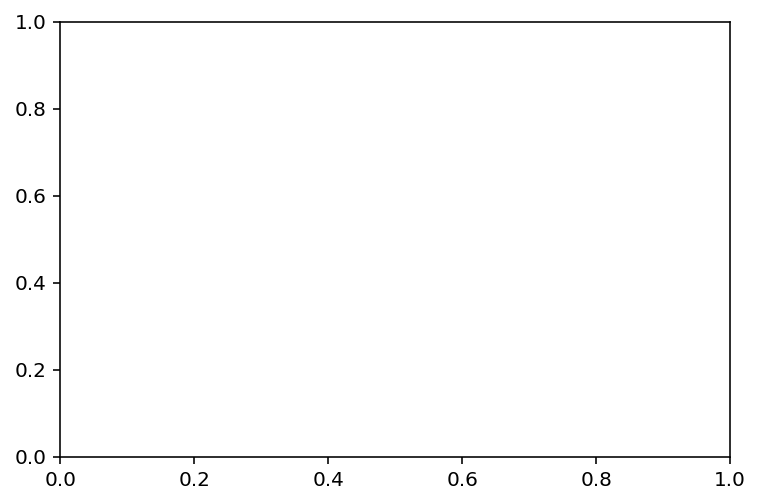

In [183]:
lr_index = 
fig, ax = plt.subplots()
im = ax.imshow(accuracy_tuning[lr_index])

# We want to show all ticks...
ax.set_xticks(np.arange(len(epochs)))
ax.set_yticks(np.arange(len(batch_sizes)))
# ... and label them with the respective list entries
ax.set_xticklabels(epochs)
ax.set_yticklabels(batch_sizes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(batch_sizes)):
    for j in range(len(epochs)):
        text = ax.text(j, i, np.around(accuracy_tuning[lr_index][i][j], decimals = 4),
                       ha="center", va="center", color="r")

ax.set_title("Accuracies")
fig.tight_layout()
plt.show()

In [0]:
autoencoder, encoder = autoencoder(dims, init=init)

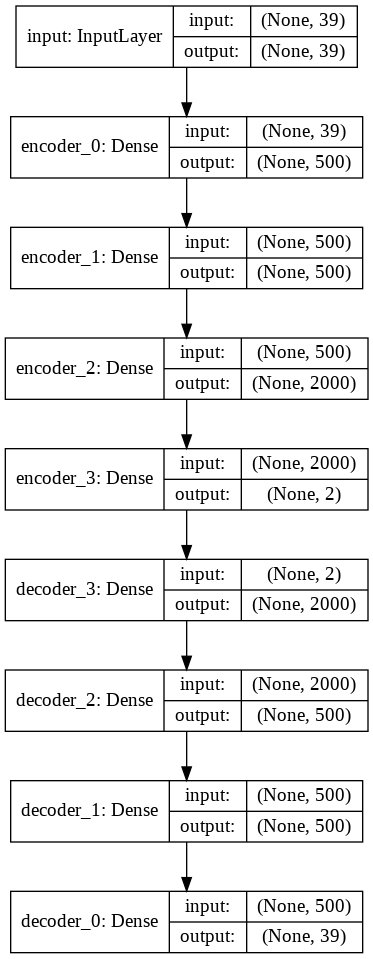

In [0]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

In [0]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` which represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [0]:
li = [i for i in range(10)]

In [0]:
bi = [i for i in range(10, 101, 10)]

In [65]:
dbs = [i for i in range(100, 9, -10)] + [i for i in range(9, -1, -1)]
dbs

[100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [104]:
time_means_start = time.time()
y_pred_train_list = []
y_pred_train_list_means = []
accuracy_list = []
accuracy_means_list = []
accuracy_ae_list = []
tsne_list = []
label_list = []
dbs = [100, 50, 30, 20, 10] + [i for i in range(9, -1, -1)]
for db in dbs:
  a = create_data(sparsity = 1, db = db)
  X = a[0]
  labels = a[1]
  np.save(os.path.join(synthetic_path, f'X_sparsity_1_db_{db}'), X)
  np.save(os.path.join(synthetic_path, f'labels_sparsity_1_db_{db}'), labels)

  #===========================#
  autoencoder, encoder = Autoencoder(dims, init=init)
  autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
  autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
  autoencoder.save_weights(os.path.join(synthetic_path, f"ae_sparsity_1_db_{db}.h5"))
  encoding = encoder.predict(X)
  np.save(os.path.join(synthetic_path, f'encoding_sparsity_1_db_{db}.npy'), encoding)
  y = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_db_{db}.npy'))
  y_pred_ae = np.argmax(encoding, axis = 1)
  accs_ae = metrics.acc(y.reshape(10002,), y_pred_ae)
  print("accuracy",db,accs_ae)
  accuracy_ae_list.append(accs_ae) 
  #============#
  # clustering_layer = ClusteringLayer(n_clusters = 2, name='clustering')(encoder.output)
  # model = Model(inputs=encoder.input, outputs=clustering_layer)
  # model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
  # k_means = KMeans(n_clusters=2, n_init=20)
  # y_pred_ae = k_means.fit_predict(encoding) 
  # y_pred_last = np.copy(y_pred_ae)
  # model.get_layer(name='clustering').set_weights([k_means.cluster_centers_])
  #===================#
  # loss = 0
  # index = 0
  # maxiter = 8000
  # update_interval = 140
  # index_array = np.arange(X.shape[0])
  # tol = 0.00001 
  # acc = 0
  # #=====================#
  # for ite in range(int(maxiter)):
  #     if ite % update_interval == 0:
  #         q = model.predict(X, verbose=0)
  #         p = target_distribution(q) 
  #         y_pred_ae = q.argmax(1)
  #         print(y_pred_ae.shape)
  #         print(labels.numpy().shape)
  #         if labels.numpy() is not None:
  #             acc = np.round(metrics.acc(labels.numpy().reshape(10002,), y_pred_ae), 5)
  #             nmi = np.round(metrics.nmi(labels.numpy().reshape(10002,), y_pred_ae), 5)
  #             ari = np.round(metrics.ari(labels.numpy().reshape(10002,), y_pred_ae), 5)
  #             loss = np.round(loss, 5)
  #             print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)
  #         delta_label = np.sum(y_pred_ae != y_pred_last).astype(np.float32) / y_pred_ae.shape[0]
  #         y_pred_last = np.copy(y_pred_ae)
  #         if ite > 0 and delta_label < tol:
  #             print('delta_label ', delta_label, '< tol ', tol)
  #             print('Reached tolerance threshold. Stopping training.')
  #             break
  #     idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
  #     loss = model.train_on_batch(x=X[idx], y=p[idx])
  #     index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0
  # accuracy_dec_list.append(acc)
  # model.save_weights(os.path.join(synthetic_path, f'DEC_model_final_sparsity_1_db{db}.h5'))
  # encoded_dec = encoder.predict(X)
  # np.save(os.path.join(synthetic_path, f'encoded_dec_sparsity_1_db_{db}.npy'), encoded_dec)
  del encoding#, loss, idx, index, model,acc,nmi, ari, clustering_layer, k_means, y_pred_last, delta_label, encoded_dec
  #===========================#

  #=========================#
  gmmodel = mixture.GaussianMixture(n_components = 2, random_state = 42)
  gmmodel.fit(X)  
  y_pred_train = gmmodel.predict(X)
  print(f'Gaussian Mixtures Models Done for db = {db}. Time elapsed = {time.time()-time_means_start:.2f}s')
  accuracy = metrics.acc(labels.numpy(), y_pred_train)
  print(f'Gaussian Mixture Model Accuracy = {(accuracy)*100:.2f}%')
  #===========================#

  #===========================#
  kmodel = KMeans(n_clusters = 2, random_state = 42)
  kmeans = kmodel.fit(X)
  print(f'KMeans completed. Time elapsed = {time.time()-time_means_start:.2f}s')
  y_pred_train_means = kmeans.labels_
  accuracy_means = metrics.acc(labels.numpy(), y_pred_train_means)
  print(f'KMeans Accuracy = {accuracy_means*100:.2f}%')
  #===========================#
  
  #===========================#
  # print(f'TSNE Started. Time elapsed = {time.time()-time_means_start:.2f}s')
  # tsne =  TSNE(n_components=2, random_state=42).fit_transform(X)
  # np.save(os.path.join(synthetic_path, f'tsne_sparsity_1_db_{db}'), tsne)
  # print(f'TSNE Completed. Time elapsed = {time.time()-time_means_start:.2f}s')
  # tsne_list.append(tsne)
  # del tsne
  #===========================#

  #===========================#
  y_pred_train_list_means.append(y_pred_train_means)
  accuracy_means_list.append(accuracy_means)
  accuracy_list.append(accuracy)
  y_pred_train_list.append(y_pred_train)
  label_list.append(labels)
  
  np.save(os.path.join(synthetic_path, f'gmm_preds_sparsity_1_db_{db}'), y_pred_train)
  np.save(os.path.join(synthetic_path, f'kmeans_preds_sparsity_1_db_{db}'), y_pred_train_means)
  del kmodel
  del autoencoder
  del encoder
  del gmmodel
  del X
  del labels
  del y_pred_train
  print(f'Done time elapsed = {time.time()-time_means_start:.2f}s')

Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 5s 545us/step - loss: 1.3319
Epoch 2/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0061
Epoch 3/30
10002/10002 [==============================] - 0s 36us/step - loss: 0.0033
Epoch 4/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0026
Epoch 5/30
10002/10002 [==============================] - 0s 33us/step - loss: 0.0026
Epoch 6/30
10002/10002 [==============================] - 0s 33us/step - loss: 0.0025
Epoch 7/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 8/30
10002/10002 [==============================] - 0s 33us/step - loss: 0.0025
Epoch 9/30
10002/10002 [==============================] - 0s 33us/step - loss: 0.0025
Epoch 10/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 11/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 12

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 100 0.5000999800039992
(10002,)
(10002, 1)
Iter 0: acc = 0.99880, nmi = 0.98783, ari = 0.99521  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.99960, nmi = 0.99531, ari = 0.99840  ; loss= 5e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.99980, nmi = 0.99745, ari = 0.99920  ; loss= 6e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.99990, nmi = 0.99863, ari = 0.99960  ; loss= 8e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.99990, nmi = 0.99863, ari = 0.99960  ; loss= 9e-05
delta_label  0.0 < tol  1e-05
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 100. Time elapsed = 47.43s
Gaussian Mixture Model Accuracy = 99.99%
KMeans completed. Time elapsed = 47.62s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 99.95%
Done time elapsed = 47.72s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 6s 563us/step - loss: 1.4379
Epoch 2/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0052
Epoch 3/30
10002/10002 [==============================] - 0s 33us/step - loss: 0.0030
Epoch 4/30
10002/10002 [==============================] - 0s 33us/step - loss: 0.0026
Epoch 5/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.0025
Epoch 6/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 7/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 8/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 9/30
10002/10002 [==============================] - 0s 33us/step - loss: 0.0025
Epoch 10/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 11/30
10002/10002 [==================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 50 0.9992001599680064
(10002,)
(10002, 1)
Iter 0: acc = 0.99990, nmi = 0.99863, ari = 0.99960  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.99990, nmi = 0.99863, ari = 0.99960  ; loss= 7e-05
delta_label  0.0 < tol  1e-05
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 50. Time elapsed = 93.96s
Gaussian Mixture Model Accuracy = 99.99%
KMeans completed. Time elapsed = 94.15s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 99.87%
Done time elapsed = 94.25s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 6s 584us/step - loss: 0.6226
Epoch 2/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.0063
Epoch 3/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0049
Epoch 4/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.0032
Epoch 5/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0027
Epoch 6/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0026
Epoch 7/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.0025
Epoch 8/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0025
Epoch 9/30
10002/10002 [==============================] - 0s 33us/step - loss: 0.0025
Epoch 10/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.0025
Epoch 11/30
10002/10002 [==================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 30 0.9999000199960008
(10002,)
(10002, 1)
Iter 0: acc = 0.99990, nmi = 0.99863, ari = 0.99960  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.99990, nmi = 0.99863, ari = 0.99960  ; loss= 6e-05
delta_label  0.0 < tol  1e-05
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 30. Time elapsed = 139.68s
Gaussian Mixture Model Accuracy = 99.99%
KMeans completed. Time elapsed = 139.86s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 99.87%
Done time elapsed = 139.96s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 6s 615us/step - loss: 1.8487
Epoch 2/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0089
Epoch 3/30
10002/10002 [==============================] - 0s 33us/step - loss: 0.0061
Epoch 4/30
10002/10002 [==============================] - 0s 37us/step - loss: 0.0058
Epoch 5/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.0042
Epoch 6/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0030
Epoch 7/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.0029
Epoch 8/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.0027
Epoch 9/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.0027
Epoch 10/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.0026
Epoch 11/30
10002/10002 [=================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 20 0.8327334533093381
(10002,)
(10002, 1)
Iter 0: acc = 0.99950, nmi = 0.99430, ari = 0.99800  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.99970, nmi = 0.99636, ari = 0.99880  ; loss= 0.00954


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.99990, nmi = 0.99863, ari = 0.99960  ; loss= 0.03351


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.99990, nmi = 0.99863, ari = 0.99960  ; loss= 0.03696
delta_label  0.0 < tol  1e-05
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 20. Time elapsed = 189.54s
Gaussian Mixture Model Accuracy = 99.99%
KMeans completed. Time elapsed = 189.72s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 99.90%
Done time elapsed = 189.81s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 6s 636us/step - loss: 37.4829
Epoch 2/30
10002/10002 [==============================] - 0s 35us/step - loss: 1.8107
Epoch 3/30
10002/10002 [==============================] - 0s 35us/step - loss: 5.5334
Epoch 4/30
10002/10002 [==============================] - 0s 34us/step - loss: 1.1305
Epoch 5/30
10002/10002 [==============================] - 0s 35us/step - loss: 2.0567
Epoch 6/30
10002/10002 [==============================] - 0s 34us/step - loss: 3.0098
Epoch 7/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.7826
Epoch 8/30
10002/10002 [==============================] - 0s 35us/step - loss: 2.5739
Epoch 9/30
10002/10002 [==============================] - 0s 33us/step - loss: 2.8095
Epoch 10/30
10002/10002 [==============================] - 0s 34us/step - loss: 1.0333
Epoch 11/30
10002/10002 [================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 10 0.500499900019996
(10002,)
(10002, 1)
Iter 0: acc = 0.98320, nmi = 0.88504, ari = 0.93394  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.98280, nmi = 0.87999, ari = 0.93239  ; loss= 1e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.98280, nmi = 0.87844, ari = 0.93239  ; loss= 1e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.98210, nmi = 0.87247, ari = 0.92969  ; loss= 1e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.98100, nmi = 0.86489, ari = 0.92545  ; loss= 2e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.97960, nmi = 0.85634, ari = 0.92007  ; loss= 2e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.97800, nmi = 0.84791, ari = 0.91394  ; loss= 3e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.97560, nmi = 0.83605, ari = 0.90479  ; loss= 3e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.97431, nmi = 0.83041, ari = 0.89985  ; loss= 5e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.97530, nmi = 0.83630, ari = 0.90365  ; loss= 6e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.98000, nmi = 0.86055, ari = 0.92161  ; loss= 8e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.98630, nmi = 0.89563, ari = 0.94596  ; loss= 1e-04


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.99200, nmi = 0.93340, ari = 0.96826  ; loss= 1e-04


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.99410, nmi = 0.94942, ari = 0.97654  ; loss= 4e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.99480, nmi = 0.95530, ari = 0.97931  ; loss= 5e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.99490, nmi = 0.95625, ari = 0.97971  ; loss= 0.00015


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.99500, nmi = 0.95757, ari = 0.98010  ; loss= 0.00073


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.99530, nmi = 0.96088, ari = 0.98129  ; loss= 0.02013


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.99530, nmi = 0.96088, ari = 0.98129  ; loss= 0.03554
delta_label  0.0 < tol  1e-05
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 10. Time elapsed = 260.05s
Gaussian Mixture Model Accuracy = 50.01%
KMeans completed. Time elapsed = 260.21s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.01%
Done time elapsed = 260.29s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 7s 662us/step - loss: 1.9124
Epoch 2/30
10002/10002 [==============================] - 0s 37us/step - loss: 1.3957
Epoch 3/30
10002/10002 [==============================] - 0s 34us/step - loss: 1.8670
Epoch 4/30
10002/10002 [==============================] - 0s 33us/step - loss: 1.1321
Epoch 5/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.6390
Epoch 6/30
10002/10002 [==============================] - 0s 35us/step - loss: 0.9227
Epoch 7/30
10002/10002 [==============================] - 0s 34us/step - loss: 1.0924
Epoch 8/30
10002/10002 [==============================] - 0s 35us/step - loss: 2.1730
Epoch 9/30
10002/10002 [==============================] - 0s 35us/step - loss: 1.2295
Epoch 10/30
10002/10002 [==============================] - 0s 34us/step - loss: 0.7041
Epoch 11/30
10002/10002 [=================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 9 0.5021995600879824
(10002,)
(10002, 1)
Iter 0: acc = 0.50030, nmi = 0.00478, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50060, nmi = 0.00703, ari = 0.00000  ; loss= 4e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.50080, nmi = 0.00826, ari = 0.00000  ; loss= 2e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.50110, nmi = 0.00989, ari = 0.00000  ; loss= 0.00023


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.50170, nmi = 0.01265, ari = 0.00001  ; loss= 5e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.50240, nmi = 0.01541, ari = 0.00002  ; loss= 0.00111


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.50320, nmi = 0.01818, ari = 0.00004  ; loss= 0.00016


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.50630, nmi = 0.02695, ari = 0.00016  ; loss= 0.00259


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.50940, nmi = 0.03415, ari = 0.00035  ; loss= 0.00077


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.51530, nmi = 0.04578, ari = 0.00093  ; loss= 0.00441


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.52330, nmi = 0.05932, ari = 0.00216  ; loss= 0.00473


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.53079, nmi = 0.07073, ari = 0.00378  ; loss= 0.00713


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.53719, nmi = 0.06782, ari = 0.00552  ; loss= 0.00896


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.53999, nmi = 0.04317, ari = 0.00638  ; loss= 0.01211


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.53429, nmi = 0.01948, ari = 0.00468  ; loss= 0.02259


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.52260, nmi = 0.00539, ari = 0.00200  ; loss= 0.02025


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.51180, nmi = 0.00108, ari = 0.00051  ; loss= 0.03303


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.50440, nmi = 0.00013, ari = 0.00002  ; loss= 0.02782


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.50090, nmi = 0.00000, ari = -0.00006  ; loss= 0.03855


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.50630, nmi = 0.00021, ari = 0.00009  ; loss= 0.03305


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.51230, nmi = 0.00072, ari = 0.00054  ; loss= 0.03741


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.51080, nmi = 0.00054, ari = 0.00040  ; loss= 0.03369


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.51420, nmi = 0.00089, ari = 0.00073  ; loss= 0.03557


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.51270, nmi = 0.00070, ari = 0.00057  ; loss= 0.03231


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.51340, nmi = 0.00075, ari = 0.00064  ; loss= 0.03334


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.51370, nmi = 0.00076, ari = 0.00067  ; loss= 0.03048


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.51160, nmi = 0.00053, ari = 0.00046  ; loss= 0.03106


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.51260, nmi = 0.00061, ari = 0.00055  ; loss= 0.0298


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.51100, nmi = 0.00046, ari = 0.00040  ; loss= 0.02863


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.51160, nmi = 0.00050, ari = 0.00045  ; loss= 0.02824


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.51170, nmi = 0.00050, ari = 0.00046  ; loss= 0.0265


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.51720, nmi = 0.00105, ari = 0.00110  ; loss= 0.02561


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.51800, nmi = 0.00115, ari = 0.00121  ; loss= 0.02273


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.52050, nmi = 0.00146, ari = 0.00159  ; loss= 0.02248


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.52020, nmi = 0.00142, ari = 0.00154  ; loss= 0.01958


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.52130, nmi = 0.00156, ari = 0.00173  ; loss= 0.01981


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.52030, nmi = 0.00142, ari = 0.00156  ; loss= 0.01872


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.52110, nmi = 0.00151, ari = 0.00169  ; loss= 0.01815


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.51980, nmi = 0.00134, ari = 0.00148  ; loss= 0.01791


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.52090, nmi = 0.00148, ari = 0.00166  ; loss= 0.01714


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.51910, nmi = 0.00125, ari = 0.00137  ; loss= 0.01681


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.52010, nmi = 0.00137, ari = 0.00153  ; loss= 0.01619


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.51850, nmi = 0.00117, ari = 0.00128  ; loss= 0.01616


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.51860, nmi = 0.00117, ari = 0.00129  ; loss= 0.0154


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.51750, nmi = 0.00104, ari = 0.00114  ; loss= 0.01631


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.51790, nmi = 0.00108, ari = 0.00119  ; loss= 0.01479


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.51700, nmi = 0.00097, ari = 0.00107  ; loss= 0.01732


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.51620, nmi = 0.00088, ari = 0.00096  ; loss= 0.01458


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.51570, nmi = 0.00083, ari = 0.00090  ; loss= 0.01794


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.51670, nmi = 0.00093, ari = 0.00103  ; loss= 0.0145


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.51600, nmi = 0.00086, ari = 0.00093  ; loss= 0.01728


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.51710, nmi = 0.00098, ari = 0.00108  ; loss= 0.01434


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.51680, nmi = 0.00094, ari = 0.00104  ; loss= 0.01661


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.51740, nmi = 0.00101, ari = 0.00112  ; loss= 0.01429


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.51740, nmi = 0.00101, ari = 0.00112  ; loss= 0.01559


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.51810, nmi = 0.00109, ari = 0.00122  ; loss= 0.01427


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.51800, nmi = 0.00108, ari = 0.00121  ; loss= 0.01475


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.51880, nmi = 0.00118, ari = 0.00132  ; loss= 0.0146


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 9. Time elapsed = 382.09s
Gaussian Mixture Model Accuracy = 50.04%
KMeans completed. Time elapsed = 382.25s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.04%
Done time elapsed = 382.34s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 7s 674us/step - loss: 18.1424
Epoch 2/30
10002/10002 [==============================] - 0s 36us/step - loss: 11.3223
Epoch 3/30
10002/10002 [==============================] - 0s 37us/step - loss: 13.7853
Epoch 4/30
10002/10002 [==============================] - 0s 35us/step - loss: 10.8525
Epoch 5/30
10002/10002 [==============================] - 0s 37us/step - loss: 9.8995
Epoch 6/30
10002/10002 [==============================] - 0s 36us/step - loss: 6.3318
Epoch 7/30
10002/10002 [==============================] - 0s 36us/step - loss: 13.0290
Epoch 8/30
10002/10002 [==============================] - 0s 35us/step - loss: 6.1322
Epoch 9/30
10002/10002 [==============================] - 0s 34us/step - loss: 21.0807
Epoch 10/30
10002/10002 [==============================] - 0s 36us/step - loss: 7.2068
Epoch 11/30
10002/10002 [===========

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 8 0.5000999800039992
(10002,)
(10002, 1)
Iter 0: acc = 0.50050, nmi = 0.00635, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50070, nmi = 0.00767, ari = 0.00000  ; loss= 0.00032


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.50140, nmi = 0.01133, ari = 0.00001  ; loss= 3e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.50290, nmi = 0.01717, ari = 0.00003  ; loss= 0.00062


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.50400, nmi = 0.02068, ari = 0.00006  ; loss= 0.00047


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.50740, nmi = 0.02963, ari = 0.00022  ; loss= 0.0025


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.51240, nmi = 0.04031, ari = 0.00061  ; loss= 0.00253


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.51930, nmi = 0.05278, ari = 0.00148  ; loss= 0.0065


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.52879, nmi = 0.06777, ari = 0.00331  ; loss= 0.00411


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.53849, nmi = 0.08164, ari = 0.00591  ; loss= 0.00948


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.55189, nmi = 0.09942, ari = 0.01075  ; loss= 0.02022


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.56629, nmi = 0.11747, ari = 0.01755  ; loss= 0.01649


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.58298, nmi = 0.13763, ari = 0.02752  ; loss= 0.02725


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.59828, nmi = 0.15573, ari = 0.03860  ; loss= 0.01952


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.61548, nmi = 0.17590, ari = 0.05330  ; loss= 0.03417


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.63027, nmi = 0.19328, ari = 0.06784  ; loss= 0.02143


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.64357, nmi = 0.20900, ari = 0.08241  ; loss= 0.03661


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.65557, nmi = 0.22333, ari = 0.09676  ; loss= 0.02268


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.66987, nmi = 0.24065, ari = 0.11537  ; loss= 0.04084


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.68526, nmi = 0.25966, ari = 0.13724  ; loss= 0.02316


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.69626, nmi = 0.27352, ari = 0.15402  ; loss= 0.03877


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.70816, nmi = 0.28881, ari = 0.17327  ; loss= 0.02208


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.71906, nmi = 0.30312, ari = 0.19189  ; loss= 0.03094


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.72705, nmi = 0.31382, ari = 0.20616  ; loss= 0.0207


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.73605, nmi = 0.32608, ari = 0.22283  ; loss= 0.02089


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.74775, nmi = 0.34240, ari = 0.24546  ; loss= 0.01782


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.75375, nmi = 0.35095, ari = 0.25750  ; loss= 0.00871


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.75875, nmi = 0.35817, ari = 0.26775  ; loss= 0.01504


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.76345, nmi = 0.36504, ari = 0.27756  ; loss= 0.00924


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.76515, nmi = 0.36755, ari = 0.28116  ; loss= 0.01344


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.77025, nmi = 0.37513, ari = 0.29208  ; loss= 0.00915


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.77165, nmi = 0.37723, ari = 0.29511  ; loss= 0.01409


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.77884, nmi = 0.38816, ari = 0.31096  ; loss= 0.00913


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.78264, nmi = 0.39402, ari = 0.31949  ; loss= 0.01379


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.78674, nmi = 0.40042, ari = 0.32883  ; loss= 0.00929


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.79074, nmi = 0.40673, ari = 0.33807  ; loss= 0.01417


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.79254, nmi = 0.40959, ari = 0.34227  ; loss= 0.00932


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.79604, nmi = 0.41521, ari = 0.35051  ; loss= 0.01382


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.79644, nmi = 0.41585, ari = 0.35145  ; loss= 0.0095


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.80004, nmi = 0.42170, ari = 0.36004  ; loss= 0.0195


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.79934, nmi = 0.42056, ari = 0.35836  ; loss= 0.00942


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.80374, nmi = 0.42777, ari = 0.36898  ; loss= 0.01414


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.80434, nmi = 0.42877, ari = 0.37044  ; loss= 0.0098


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.80884, nmi = 0.43627, ari = 0.38147  ; loss= 0.01409


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.80994, nmi = 0.43812, ari = 0.38419  ; loss= 0.01141


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.81264, nmi = 0.44268, ari = 0.39092  ; loss= 0.01279


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.81414, nmi = 0.44524, ari = 0.39468  ; loss= 0.01301


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.81614, nmi = 0.44867, ari = 0.39972  ; loss= 0.01296


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.81614, nmi = 0.44867, ari = 0.39972  ; loss= 0.01344


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.81874, nmi = 0.45100, ari = 0.40632  ; loss= 0.01257


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.82044, nmi = 0.45396, ari = 0.41067  ; loss= 0.01265


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.82094, nmi = 0.45484, ari = 0.41195  ; loss= 0.01329


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.82274, nmi = 0.45800, ari = 0.41658  ; loss= 0.01128


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.82334, nmi = 0.45905, ari = 0.41813  ; loss= 0.01411


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.82503, nmi = 0.46206, ari = 0.42254  ; loss= 0.01048


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.82803, nmi = 0.46741, ari = 0.43038  ; loss= 0.01736


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.83003, nmi = 0.47101, ari = 0.43564  ; loss= 0.01471


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.83103, nmi = 0.47282, ari = 0.43828  ; loss= 0.01187


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 8. Time elapsed = 505.97s
Gaussian Mixture Model Accuracy = 50.01%
KMeans completed. Time elapsed = 506.11s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.01%
Done time elapsed = 506.19s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 7s 711us/step - loss: 40.6423
Epoch 2/30
10002/10002 [==============================] - 0s 36us/step - loss: 14.6410
Epoch 3/30
10002/10002 [==============================] - 0s 34us/step - loss: 7.7369
Epoch 4/30
10002/10002 [==============================] - 0s 35us/step - loss: 15.5165
Epoch 5/30
10002/10002 [==============================] - 0s 35us/step - loss: 13.2245
Epoch 6/30
10002/10002 [==============================] - 0s 35us/step - loss: 13.4633
Epoch 7/30
10002/10002 [==============================] - 0s 34us/step - loss: 8.1921
Epoch 8/30
10002/10002 [==============================] - 0s 35us/step - loss: 17.6850
Epoch 9/30
10002/10002 [==============================] - 0s 35us/step - loss: 16.0727
Epoch 10/30
10002/10002 [==============================] - 0s 34us/step - loss: 15.2453
Epoch 11/30
10002/10002 [=========

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 7 0.9058188362327535
(10002,)
(10002, 1)
Iter 0: acc = 0.50030, nmi = 0.00478, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50080, nmi = 0.00826, ari = 0.00000  ; loss= 0.00297


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.50120, nmi = 0.01038, ari = 0.00001  ; loss= 8e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.50250, nmi = 0.01577, ari = 0.00002  ; loss= 0.00053


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.50590, nmi = 0.02594, ari = 0.00014  ; loss= 0.00336


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.51120, nmi = 0.03792, ari = 0.00050  ; loss= 0.00377


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.51500, nmi = 0.04524, ari = 0.00089  ; loss= 0.00204


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.51920, nmi = 0.05261, ari = 0.00147  ; loss= 0.00862


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.52390, nmi = 0.06027, ari = 0.00227  ; loss= 0.01022


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.52799, nmi = 0.06658, ari = 0.00312  ; loss= 0.01274


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.53349, nmi = 0.07463, ari = 0.00447  ; loss= 0.01847


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.53869, nmi = 0.08191, ari = 0.00597  ; loss= 0.01446


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.54469, nmi = 0.09002, ari = 0.00797  ; loss= 0.02296


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.55109, nmi = 0.09839, ari = 0.01042  ; loss= 0.0141


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.56019, nmi = 0.10992, ari = 0.01447  ; loss= 0.0346


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.57239, nmi = 0.12490, ari = 0.02093  ; loss= 0.01639


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.58568, nmi = 0.14084, ari = 0.02934  ; loss= 0.03879


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.60168, nmi = 0.15972, ari = 0.04132  ; loss= 0.01767


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.61628, nmi = 0.17684, ari = 0.05404  ; loss= 0.03198


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.63267, nmi = 0.19611, ari = 0.07037  ; loss= 0.02051


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.64897, nmi = 0.21543, ari = 0.08872  ; loss= 0.03171


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.66487, nmi = 0.23456, ari = 0.10868  ; loss= 0.02406


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.67956, nmi = 0.25257, ari = 0.12892  ; loss= 0.03571


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.69446, nmi = 0.27123, ari = 0.15121  ; loss= 0.02544


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.70876, nmi = 0.28959, ari = 0.17427  ; loss= 0.03961


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.71816, nmi = 0.30192, ari = 0.19031  ; loss= 0.02628


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.73065, nmi = 0.31870, ari = 0.21275  ; loss= 0.04117


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.74245, nmi = 0.33495, ari = 0.23507  ; loss= 0.02801


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.75415, nmi = 0.35152, ari = 0.25831  ; loss= 0.04242


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.76635, nmi = 0.36932, ari = 0.28371  ; loss= 0.02927


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.77994, nmi = 0.38985, ari = 0.31342  ; loss= 0.04131


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.79434, nmi = 0.41247, ari = 0.34649  ; loss= 0.03033


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.80404, nmi = 0.42827, ari = 0.36971  ; loss= 0.03667


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.81814, nmi = 0.45212, ari = 0.40479  ; loss= 0.03076


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.83033, nmi = 0.47369, ari = 0.43643  ; loss= 0.03408


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.84063, nmi = 0.49148, ari = 0.46407  ; loss= 0.02975


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.85063, nmi = 0.50966, ari = 0.49172  ; loss= 0.04012


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.86243, nmi = 0.53237, ari = 0.52537  ; loss= 0.02768


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.87323, nmi = 0.55198, ari = 0.55715  ; loss= 0.04601


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.88322, nmi = 0.57466, ari = 0.58740  ; loss= 0.02636


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.89822, nmi = 0.60964, ari = 0.63428  ; loss= 0.04431


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.90802, nmi = 0.63469, ari = 0.66588  ; loss= 0.02569


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.91862, nmi = 0.66185, ari = 0.70093  ; loss= 0.03918


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.92741, nmi = 0.68705, ari = 0.73071  ; loss= 0.02395


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.93641, nmi = 0.71359, ari = 0.76180  ; loss= 0.0342


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.94371, nmi = 0.73778, ari = 0.78750  ; loss= 0.02159


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.95451, nmi = 0.77392, ari = 0.82630  ; loss= 0.02913


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.96171, nmi = 0.80146, ari = 0.85268  ; loss= 0.01866


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.96861, nmi = 0.82817, ari = 0.87836  ; loss= 0.02336


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.97361, nmi = 0.84978, ari = 0.89720  ; loss= 0.01466


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.97720, nmi = 0.86547, ari = 0.91089  ; loss= 0.01744


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.98070, nmi = 0.88150, ari = 0.92430  ; loss= 0.00989


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.98130, nmi = 0.88344, ari = 0.92661  ; loss= 0.01414


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.98150, nmi = 0.88439, ari = 0.92738  ; loss= 0.00882


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.98090, nmi = 0.88244, ari = 0.92507  ; loss= 0.01501


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.98210, nmi = 0.88727, ari = 0.92969  ; loss= 0.00818


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.98180, nmi = 0.88583, ari = 0.92853  ; loss= 0.01435


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.98180, nmi = 0.88583, ari = 0.92853  ; loss= 0.00736


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 7. Time elapsed = 631.25s
Gaussian Mixture Model Accuracy = 50.03%
KMeans completed. Time elapsed = 631.41s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.03%
Done time elapsed = 631.49s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 7s 729us/step - loss: 1798392.6257
Epoch 2/30
10002/10002 [==============================] - 0s 35us/step - loss: 404876.8818
Epoch 3/30
10002/10002 [==============================] - 0s 34us/step - loss: 6733310.8518
Epoch 4/30
10002/10002 [==============================] - 0s 35us/step - loss: 751572.1150
Epoch 5/30
10002/10002 [==============================] - 0s 34us/step - loss: 523457.7633
Epoch 6/30
10002/10002 [==============================] - 0s 34us/step - loss: 552218.5499
Epoch 7/30
10002/10002 [==============================] - 0s 35us/step - loss: 427156035.2262
Epoch 8/30
10002/10002 [==============================] - 0s 34us/step - loss: 843897.7866
Epoch 9/30
10002/10002 [==============================] - 0s 34us/step - loss: 906531.5178
Epoch 10/30
10002/10002 [==============================] - 0s 34us/step - loss:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 6 0.5
(10002,)
(10002, 1)
Iter 0: acc = 0.50010, nmi = 0.00261, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50010, nmi = 0.00261, ari = 0.00000  ; loss= 0.0
delta_label  0.0 < tol  1e-05
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 6. Time elapsed = 685.62s
Gaussian Mixture Model Accuracy = 50.01%
KMeans completed. Time elapsed = 685.76s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.01%
Done time elapsed = 685.84s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 8s 752us/step - loss: 170.4820
Epoch 2/30
10002/10002 [==============================] - 0s 35us/step - loss: 24.1740
Epoch 3/30
10002/10002 [==============================] - 0s 35us/step - loss: 25.8914
Epoch 4/30
10002/10002 [==============================] - 0s 35us/step - loss: 13.5972
Epoch 5/30
10002/10002 [==============================] - 0s 35us/step - loss: 36.2816
Epoch 6/30
10002/10002 [==============================] - 0s 35us/step - loss: 45.5712
Epoch 7/30
10002/10002 [==============================] - 0s 35us/step - loss: 11.0682
Epoch 8/30
10002/10002 [==============================] - 0s 35us/step - loss: 33.1879
Epoch 9/30
10002/10002 [==============================] - 0s 37us/step - loss: 29.6774
Epoch 10/30
10002/10002 [==============================] - 0s 35us/step - loss: 6.7800
Epoch 11/30
10002/10002 [=======

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 5 0.5377924415116977
(10002,)
(10002, 1)
Iter 0: acc = 0.50010, nmi = 0.00261, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50060, nmi = 0.00703, ari = 0.00000  ; loss= 3e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.50130, nmi = 0.01087, ari = 0.00001  ; loss= 0.00014


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.50230, nmi = 0.01504, ari = 0.00002  ; loss= 0.00022


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.50520, nmi = 0.02409, ari = 0.00011  ; loss= 0.00116


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.50820, nmi = 0.03149, ari = 0.00027  ; loss= 0.00224


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.51340, nmi = 0.04224, ari = 0.00071  ; loss= 0.00316


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.51940, nmi = 0.05295, ari = 0.00150  ; loss= 0.00622


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.52509, nmi = 0.06215, ari = 0.00251  ; loss= 0.01202


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.53039, nmi = 0.07014, ari = 0.00368  ; loss= 0.00827


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.53549, nmi = 0.07746, ari = 0.00503  ; loss= 0.02836


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.54129, nmi = 0.08546, ari = 0.00680  ; loss= 0.01009


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.54769, nmi = 0.09397, ari = 0.00908  ; loss= 0.0343


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.55499, nmi = 0.10338, ari = 0.01207  ; loss= 0.01335


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.55999, nmi = 0.10967, ari = 0.01437  ; loss= 0.02921


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.56529, nmi = 0.11220, ari = 0.01703  ; loss= 0.01561


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.57179, nmi = 0.11465, ari = 0.02059  ; loss= 0.03266


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.57648, nmi = 0.11079, ari = 0.02337  ; loss= 0.01756


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.57658, nmi = 0.08536, ari = 0.02343  ; loss= 0.03292


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.56869, nmi = 0.05138, ari = 0.01883  ; loss= 0.01974


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.55039, nmi = 0.02006, ari = 0.01011  ; loss= 0.03214


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.52440, nmi = 0.00361, ari = 0.00232  ; loss= 0.02034


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.50250, nmi = 0.00003, ari = -0.00004  ; loss= 0.0333


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.52969, nmi = 0.00387, ari = 0.00345  ; loss= 0.02075


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.54879, nmi = 0.00965, ari = 0.00944  ; loss= 0.03451


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.57039, nmi = 0.01866, ari = 0.01974  ; loss= 0.02065


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.58408, nmi = 0.02558, ari = 0.02820  ; loss= 0.03454


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.59928, nmi = 0.03436, ari = 0.03934  ; loss= 0.02063


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.60988, nmi = 0.04105, ari = 0.04821  ; loss= 0.02986


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.62128, nmi = 0.04872, ari = 0.05875  ; loss= 0.02127


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.63197, nmi = 0.05638, ari = 0.06958  ; loss= 0.02532


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.64277, nmi = 0.06478, ari = 0.08145  ; loss= 0.02146


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.64937, nmi = 0.07021, ari = 0.08916  ; loss= 0.02453


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.65987, nmi = 0.07940, ari = 0.10214  ; loss= 0.02042


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.66567, nmi = 0.08463, ari = 0.10970  ; loss= 0.02457


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.66997, nmi = 0.08855, ari = 0.11547  ; loss= 0.01986


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.67586, nmi = 0.09424, ari = 0.12363  ; loss= 0.02392


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.67956, nmi = 0.09801, ari = 0.12889  ; loss= 0.01846


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.68356, nmi = 0.10213, ari = 0.13470  ; loss= 0.02305


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.68586, nmi = 0.10454, ari = 0.13810  ; loss= 0.01711


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.68706, nmi = 0.10578, ari = 0.13988  ; loss= 0.02095


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.68906, nmi = 0.10795, ari = 0.14289  ; loss= 0.01622


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.69126, nmi = 0.11038, ari = 0.14624  ; loss= 0.01901


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.69246, nmi = 0.11172, ari = 0.14808  ; loss= 0.01554


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.69316, nmi = 0.11250, ari = 0.14916  ; loss= 0.01724


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.69416, nmi = 0.11363, ari = 0.15071  ; loss= 0.01477


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.69436, nmi = 0.11393, ari = 0.15102  ; loss= 0.01597


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.69586, nmi = 0.11562, ari = 0.15336  ; loss= 0.0138


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.69546, nmi = 0.11518, ari = 0.15274  ; loss= 0.01484


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.69686, nmi = 0.11678, ari = 0.15493  ; loss= 0.01283


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.69666, nmi = 0.11657, ari = 0.15462  ; loss= 0.0138


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.69796, nmi = 0.11805, ari = 0.15667  ; loss= 0.01185


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.69746, nmi = 0.11753, ari = 0.15588  ; loss= 0.01271


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.69866, nmi = 0.11889, ari = 0.15778  ; loss= 0.01091


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.69826, nmi = 0.11855, ari = 0.15715  ; loss= 0.01174


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.69966, nmi = 0.12009, ari = 0.15937  ; loss= 0.00996


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.69886, nmi = 0.11929, ari = 0.15810  ; loss= 0.0106


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.70016, nmi = 0.12070, ari = 0.16017  ; loss= 0.00891


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 5. Time elapsed = 816.24s
Gaussian Mixture Model Accuracy = 50.01%
KMeans completed. Time elapsed = 816.39s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.01%
Done time elapsed = 816.48s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 8s 771us/step - loss: 67.9898
Epoch 2/30
10002/10002 [==============================] - 0s 37us/step - loss: 28.1497
Epoch 3/30
10002/10002 [==============================] - 0s 34us/step - loss: 30.4177
Epoch 4/30
10002/10002 [==============================] - 0s 34us/step - loss: 42.7666
Epoch 5/30
10002/10002 [==============================] - 0s 36us/step - loss: 24.4325
Epoch 6/30
10002/10002 [==============================] - 0s 35us/step - loss: 15.9906
Epoch 7/30
10002/10002 [==============================] - 0s 34us/step - loss: 24.7845
Epoch 8/30
10002/10002 [==============================] - 0s 35us/step - loss: 25.8763
Epoch 9/30
10002/10002 [==============================] - 0s 35us/step - loss: 14.4578
Epoch 10/30
10002/10002 [==============================] - 0s 35us/step - loss: 43.5126
Epoch 11/30
10002/10002 [=======

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 4 0.5
(10002,)
(10002, 1)
Iter 0: acc = 0.50020, nmi = 0.00382, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50040, nmi = 0.00561, ari = 0.00000  ; loss= 3e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.50080, nmi = 0.00826, ari = 0.00000  ; loss= 3e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.50220, nmi = 0.01466, ari = 0.00002  ; loss= 0.00016


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.50460, nmi = 0.02243, ari = 0.00008  ; loss= 0.00016


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.50840, nmi = 0.03194, ari = 0.00028  ; loss= 0.00162


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.51460, nmi = 0.04450, ari = 0.00085  ; loss= 0.0013


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.52220, nmi = 0.05756, ari = 0.00196  ; loss= 0.00649


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.52929, nmi = 0.06852, ari = 0.00342  ; loss= 0.00295


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.53709, nmi = 0.07970, ari = 0.00549  ; loss= 0.01208


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.54319, nmi = 0.08802, ari = 0.00745  ; loss= 0.00272


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.54899, nmi = 0.09567, ari = 0.00958  ; loss= 0.0137


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.55449, nmi = 0.10274, ari = 0.01186  ; loss= 0.00256


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.56129, nmi = 0.11129, ari = 0.01500  ; loss= 0.01453


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.56609, nmi = 0.11722, ari = 0.01745  ; loss= 0.00624


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.56969, nmi = 0.11375, ari = 0.01940  ; loss= 0.01565


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.57508, nmi = 0.11284, ari = 0.02252  ; loss= 0.01239


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.57738, nmi = 0.09738, ari = 0.02392  ; loss= 0.01839


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.57638, nmi = 0.07547, ari = 0.02330  ; loss= 0.01337


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.56689, nmi = 0.04476, ari = 0.01785  ; loss= 0.02297


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.55149, nmi = 0.01994, ari = 0.01056  ; loss= 0.01422


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.53149, nmi = 0.00605, ari = 0.00391  ; loss= 0.02508


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.50400, nmi = 0.00008, ari = -0.00000  ; loss= 0.00577


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.52190, nmi = 0.00213, ari = 0.00185  ; loss= 0.02425


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.54149, nmi = 0.00708, ari = 0.00681  ; loss= 0.00141


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.55879, nmi = 0.01330, ari = 0.01374  ; loss= 0.0226


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.57019, nmi = 0.01829, ari = 0.01962  ; loss= 0.00353


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.58338, nmi = 0.02484, ari = 0.02773  ; loss= 0.02089


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.59368, nmi = 0.03050, ari = 0.03502  ; loss= 0.00865


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.60318, nmi = 0.03609, ari = 0.04250  ; loss= 0.02112


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.61218, nmi = 0.04181, ari = 0.05025  ; loss= 0.00961


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.61898, nmi = 0.04627, ari = 0.05653  ; loss= 0.02294


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.62747, nmi = 0.05225, ari = 0.06491  ; loss= 0.01047


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.63387, nmi = 0.05699, ari = 0.07160  ; loss= 0.02396


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.64127, nmi = 0.06271, ari = 0.07974  ; loss= 0.01081


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.64697, nmi = 0.06724, ari = 0.08631  ; loss= 0.02323


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.65317, nmi = 0.07246, ari = 0.09376  ; loss= 0.011


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.65847, nmi = 0.07710, ari = 0.10036  ; loss= 0.02176


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.66267, nmi = 0.08089, ari = 0.10576  ; loss= 0.01082


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.66807, nmi = 0.08595, ari = 0.11290  ; loss= 0.02058


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.67127, nmi = 0.08900, ari = 0.11724  ; loss= 0.01055


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.67516, nmi = 0.09278, ari = 0.12264  ; loss= 0.02001


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.67836, nmi = 0.09602, ari = 0.12717  ; loss= 0.01015


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.68106, nmi = 0.09879, ari = 0.13105  ; loss= 0.01976


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.68356, nmi = 0.10143, ari = 0.13470  ; loss= 0.00967


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.68506, nmi = 0.10300, ari = 0.13691  ; loss= 0.01937


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.68636, nmi = 0.10439, ari = 0.13884  ; loss= 0.00908


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.68816, nmi = 0.10634, ari = 0.14154  ; loss= 0.01876


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.68856, nmi = 0.10676, ari = 0.14214  ; loss= 0.00843


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.68946, nmi = 0.10777, ari = 0.14350  ; loss= 0.01798


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.69036, nmi = 0.10878, ari = 0.14487  ; loss= 0.00781


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.69086, nmi = 0.10935, ari = 0.14563  ; loss= 0.01711


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.69166, nmi = 0.11023, ari = 0.14685  ; loss= 0.00712


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.69236, nmi = 0.11100, ari = 0.14793  ; loss= 0.01614


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.69316, nmi = 0.11190, ari = 0.14916  ; loss= 0.00638


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.69346, nmi = 0.11222, ari = 0.14962  ; loss= 0.01511


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.69356, nmi = 0.11233, ari = 0.14978  ; loss= 0.00551


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.69386, nmi = 0.11266, ari = 0.15024  ; loss= 0.01404


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 4. Time elapsed = 947.73s
Gaussian Mixture Model Accuracy = 50.01%
KMeans completed. Time elapsed = 947.89s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.03%
Done time elapsed = 947.98s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 8s 811us/step - loss: 2193.8921
Epoch 2/30
10002/10002 [==============================] - 0s 35us/step - loss: 224.1357
Epoch 3/30
10002/10002 [==============================] - 0s 36us/step - loss: 1019.4596
Epoch 4/30
10002/10002 [==============================] - 0s 35us/step - loss: 61.9033
Epoch 5/30
10002/10002 [==============================] - 0s 34us/step - loss: 156.0600
Epoch 6/30
10002/10002 [==============================] - 0s 35us/step - loss: 144.1998
Epoch 7/30
10002/10002 [==============================] - 0s 34us/step - loss: 15361.7880
Epoch 8/30
10002/10002 [==============================] - 0s 34us/step - loss: 579.2266
Epoch 9/30
10002/10002 [==============================] - 0s 36us/step - loss: 556.8583
Epoch 10/30
10002/10002 [==============================] - 0s 35us/step - loss: 38.5614
Epoch 11/30
10002/10

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 3 0.5626874625074985
(10002,)
(10002, 1)
Iter 0: acc = 0.50010, nmi = 0.00261, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50010, nmi = 0.00261, ari = 0.00000  ; loss= 0.0
delta_label  0.0 < tol  1e-05
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 3. Time elapsed = 1006.79s
Gaussian Mixture Model Accuracy = 50.01%
KMeans completed. Time elapsed = 1006.93s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.01%
Done time elapsed = 1007.02s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 8s 848us/step - loss: 12.0567
Epoch 2/30
10002/10002 [==============================] - 0s 36us/step - loss: 34.0486
Epoch 3/30
10002/10002 [==============================] - 0s 36us/step - loss: 19.4025
Epoch 4/30
10002/10002 [==============================] - 0s 37us/step - loss: 13.7078
Epoch 5/30
10002/10002 [==============================] - 0s 37us/step - loss: 19.1638
Epoch 6/30
10002/10002 [==============================] - 0s 37us/step - loss: 18.9624
Epoch 7/30
10002/10002 [==============================] - 0s 36us/step - loss: 19.6640
Epoch 8/30
10002/10002 [==============================] - 0s 36us/step - loss: 51.5645
Epoch 9/30
10002/10002 [==============================] - 0s 36us/step - loss: 35.0155
Epoch 10/30
10002/10002 [==============================] - 0s 36us/step - loss: 15.6027
Epoch 11/30
10002/10002 [======

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 2 0.5016996600679864
(10002,)
(10002, 1)
Iter 0: acc = 0.50010, nmi = 0.00261, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50030, nmi = 0.00478, ari = 0.00000  ; loss= 0.0016


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.50070, nmi = 0.00767, ari = 0.00000  ; loss= 6e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.50230, nmi = 0.01504, ari = 0.00002  ; loss= 0.00205


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.50640, nmi = 0.02721, ari = 0.00016  ; loss= 0.00091


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.51170, nmi = 0.03893, ari = 0.00054  ; loss= 0.00466


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.51870, nmi = 0.05177, ari = 0.00139  ; loss= 0.0057


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.52490, nmi = 0.06184, ari = 0.00247  ; loss= 0.0106


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.53189, nmi = 0.07233, ari = 0.00406  ; loss= 0.00653


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.53839, nmi = 0.08150, ari = 0.00588  ; loss= 0.01877


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.54569, nmi = 0.09134, ari = 0.00833  ; loss= 0.00654


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.55149, nmi = 0.09890, ari = 0.01059  ; loss= 0.01772


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.55819, nmi = 0.10742, ari = 0.01352  ; loss= 0.01169


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.56239, nmi = 0.11102, ari = 0.01555  ; loss= 0.01772


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.56809, nmi = 0.11362, ari = 0.01852  ; loss= 0.01587


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.57279, nmi = 0.11001, ari = 0.02116  ; loss= 0.02015


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.57499, nmi = 0.09697, ari = 0.02246  ; loss= 0.01823


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.56839, nmi = 0.05618, ari = 0.01867  ; loss= 0.02418


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.55189, nmi = 0.02351, ari = 0.01073  ; loss= 0.02296


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.52420, nmi = 0.00375, ari = 0.00229  ; loss= 0.02615


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.50260, nmi = 0.00004, ari = -0.00004  ; loss= 0.02505


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.53019, nmi = 0.00412, ari = 0.00357  ; loss= 0.02533


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.55339, nmi = 0.01166, ari = 0.01132  ; loss= 0.02055


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.57489, nmi = 0.02136, ari = 0.02235  ; loss= 0.0268


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.58878, nmi = 0.02854, ari = 0.03145  ; loss= 0.01922


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.60328, nmi = 0.03722, ari = 0.04258  ; loss= 0.02935


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.61428, nmi = 0.04444, ari = 0.05215  ; loss= 0.02126


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.62208, nmi = 0.04980, ari = 0.05952  ; loss= 0.02958


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.62757, nmi = 0.05385, ari = 0.06502  ; loss= 0.01884


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.63397, nmi = 0.05858, ari = 0.07171  ; loss= 0.02831


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.63737, nmi = 0.06116, ari = 0.07540  ; loss= 0.01795


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.64207, nmi = 0.06485, ari = 0.08065  ; loss= 0.02804


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.64457, nmi = 0.06676, ari = 0.08352  ; loss= 0.01726


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.64937, nmi = 0.07078, ari = 0.08916  ; loss= 0.02778


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.65227, nmi = 0.07315, ari = 0.09266  ; loss= 0.01694


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.65587, nmi = 0.07618, ari = 0.09709  ; loss= 0.02757


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.65867, nmi = 0.07859, ari = 0.10062  ; loss= 0.01704


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.66287, nmi = 0.08234, ari = 0.10602  ; loss= 0.02722


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.66647, nmi = 0.08556, ari = 0.11076  ; loss= 0.0175


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.66957, nmi = 0.08839, ari = 0.11492  ; loss= 0.02664


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.67357, nmi = 0.09216, ari = 0.12041  ; loss= 0.01827


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.67686, nmi = 0.09532, ari = 0.12504  ; loss= 0.02609


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.68016, nmi = 0.09864, ari = 0.12975  ; loss= 0.01891


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.68246, nmi = 0.10099, ari = 0.13309  ; loss= 0.02559


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.68416, nmi = 0.10270, ari = 0.13558  ; loss= 0.01894


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.68606, nmi = 0.10466, ari = 0.13839  ; loss= 0.02499


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.68806, nmi = 0.10679, ari = 0.14139  ; loss= 0.01844


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.68946, nmi = 0.10828, ari = 0.14350  ; loss= 0.02417


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.69076, nmi = 0.10969, ari = 0.14548  ; loss= 0.01761


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.69186, nmi = 0.11081, ari = 0.14716  ; loss= 0.02314


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.69286, nmi = 0.11194, ari = 0.14870  ; loss= 0.01666


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.69416, nmi = 0.11338, ari = 0.15071  ; loss= 0.02202


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.69426, nmi = 0.11347, ari = 0.15087  ; loss= 0.01577


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.69506, nmi = 0.11434, ari = 0.15211  ; loss= 0.02076


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.69536, nmi = 0.11469, ari = 0.15258  ; loss= 0.01486


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.69556, nmi = 0.11489, ari = 0.15289  ; loss= 0.01947


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.69576, nmi = 0.11514, ari = 0.15321  ; loss= 0.01379


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.69676, nmi = 0.11628, ari = 0.15478  ; loss= 0.01807


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 2. Time elapsed = 1144.57s
Gaussian Mixture Model Accuracy = 50.01%
KMeans completed. Time elapsed = 1144.72s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.01%
Done time elapsed = 1144.81s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 9s 861us/step - loss: 64.1753
Epoch 2/30
10002/10002 [==============================] - 0s 36us/step - loss: 28.2020
Epoch 3/30
10002/10002 [==============================] - 0s 35us/step - loss: 50.7792
Epoch 4/30
10002/10002 [==============================] - 0s 35us/step - loss: 48.9091
Epoch 5/30
10002/10002 [==============================] - 0s 35us/step - loss: 52.9015
Epoch 6/30
10002/10002 [==============================] - 0s 36us/step - loss: 16.9390
Epoch 7/30
10002/10002 [==============================] - 0s 36us/step - loss: 33.0494
Epoch 8/30
10002/10002 [==============================] - 0s 35us/step - loss: 5.0067
Epoch 9/30
10002/10002 [==============================] - 0s 35us/step - loss: 2.7905
Epoch 10/30
10002/10002 [==============================] - 0s 35us/step - loss: 17.6311
Epoch 11/30
10002/10002 [========

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1 0.5230953809238152
(10002,)
(10002, 1)
Iter 0: acc = 0.50010, nmi = 0.00261, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50020, nmi = 0.00382, ari = 0.00000  ; loss= 1e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.50100, nmi = 0.00937, ari = 0.00000  ; loss= 3e-05


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.50250, nmi = 0.01577, ari = 0.00002  ; loss= 0.00015


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.50500, nmi = 0.02354, ari = 0.00010  ; loss= 0.00043


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.50800, nmi = 0.03103, ari = 0.00025  ; loss= 0.00122


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.51410, nmi = 0.04357, ari = 0.00079  ; loss= 0.0017


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.52669, nmi = 0.06461, ari = 0.00284  ; loss= 0.00393


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.53849, nmi = 0.08164, ari = 0.00591  ; loss= 0.00418


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.54969, nmi = 0.09658, ari = 0.00986  ; loss= 0.00795


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.55749, nmi = 0.10654, ari = 0.01320  ; loss= 0.00527


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.56379, nmi = 0.11439, ari = 0.01625  ; loss= 0.00991


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.57209, nmi = 0.12454, ari = 0.02076  ; loss= 0.01403


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.57908, nmi = 0.13297, ari = 0.02499  ; loss= 0.01239


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.58548, nmi = 0.14061, ari = 0.02920  ; loss= 0.00902


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.58998, nmi = 0.14323, ari = 0.03236  ; loss= 0.01761


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.59468, nmi = 0.14772, ari = 0.03582  ; loss= 0.00695


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.59798, nmi = 0.15062, ari = 0.03837  ; loss= 0.01862


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.60238, nmi = 0.15489, ari = 0.04189  ; loss= 0.00699


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.60448, nmi = 0.15647, ari = 0.04363  ; loss= 0.01914


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.60708, nmi = 0.15868, ari = 0.04583  ; loss= 0.00638


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.60968, nmi = 0.16262, ari = 0.04808  ; loss= 0.01892


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.61098, nmi = 0.16598, ari = 0.04923  ; loss= 0.00563


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.61288, nmi = 0.16920, ari = 0.05093  ; loss= 0.01768


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.61488, nmi = 0.17156, ari = 0.05275  ; loss= 0.01027


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.61728, nmi = 0.17543, ari = 0.05498  ; loss= 0.01654


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.61868, nmi = 0.17823, ari = 0.05630  ; loss= 0.02145


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.62078, nmi = 0.18070, ari = 0.05831  ; loss= 0.01548


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.62098, nmi = 0.18235, ari = 0.05850  ; loss= 0.01627


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.62188, nmi = 0.18341, ari = 0.05937  ; loss= 0.01414


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.62338, nmi = 0.18517, ari = 0.06085  ; loss= 0.00928


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.62428, nmi = 0.18622, ari = 0.06174  ; loss= 0.01527


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.62657, nmi = 0.18893, ari = 0.06404  ; loss= 0.00626


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.62797, nmi = 0.19057, ari = 0.06547  ; loss= 0.01402


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.62937, nmi = 0.19222, ari = 0.06691  ; loss= 0.0051


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.63047, nmi = 0.19351, ari = 0.06805  ; loss= 0.01157


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.63157, nmi = 0.19481, ari = 0.06920  ; loss= 0.00488


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.63207, nmi = 0.19540, ari = 0.06973  ; loss= 0.01012


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.63227, nmi = 0.19564, ari = 0.06994  ; loss= 0.00477


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.63267, nmi = 0.19611, ari = 0.07037  ; loss= 0.0089


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.63267, nmi = 0.19611, ari = 0.07037  ; loss= 0.00474
delta_label  0.0 < tol  1e-05
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 1. Time elapsed = 1263.59s
Gaussian Mixture Model Accuracy = 50.01%
KMeans completed. Time elapsed = 1263.74s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 50.01%
Done time elapsed = 1263.85s
Creating Uniform data
Creating Sparse data
Epoch 1/30
10002/10002 [==============================] - 9s 874us/step - loss: 3430.0610
Epoch 2/30
10002/10002 [==============================] - 0s 36us/step - loss: 18100.9672
Epoch 3/30
10002/10002 [==============================] - 0s 36us/step - loss: 1940.1215
Epoch 4/30
10002/10002 [==============================] - 0s 34us/step - loss: 6519.8199
Epoch 5/30
10002/10002 [==============================] - 0s 36us/step - loss: 4415.9616
Epoch 6/30
10002/10002 [==============================] - 0s 35us/step - loss: 3459.2210
Epoch 7/30
10002/10002 [==============================] - 0s 35us/step - loss: 6181.5999
Epoch 8/30
10002/10002 [==============================] - 0s 35us/step - loss: 96648.8531
Epoch 9/30
10002/10002 [==============================] - 0s 36us/step - loss: 1088.6520
Epoch 10/30
10002/10002 [==============================] - 0s 35us/step - loss: 13517.1262
Epoch 11

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0 0.5
(10002,)
(10002, 1)
Iter 0: acc = 0.50010, nmi = 0.00261, ari = 0.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.50010, nmi = 0.00261, ari = 0.00000  ; loss= 0.0
delta_label  0.0 < tol  1e-05
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for db = 0. Time elapsed = 1327.22s
Gaussian Mixture Model Accuracy = 50.01%
KMeans completed. Time elapsed = 1327.37s
KMeans Accuracy = 50.01%
Done time elapsed = 1327.46s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [0]:
np.sum(y_pred_train_list[0])

143

### Visualization and Evaluation

In [121]:
len(accuracy_dec_list[14:])

15

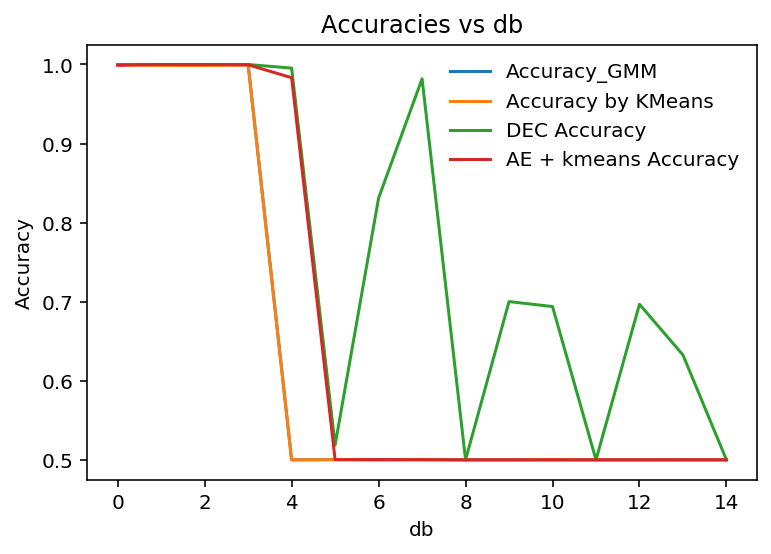

In [152]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(accuracy_list, label='Accuracy_GMM')
plt.plot(accuracy_means_list, label = 'Accuracy by KMeans')
plt.xlabel('db')
plt.ylabel("Accuracy")
plt.plot(accuracy_dec_list[14:], label='DEC Accuracy')
plt.plot(accuracy_ae_means_list, label = 'AE + kmeans Accuracy')
# plt.plot(accuracy_ae_list, label = 'AE Accuracy')
plt.legend(frameon=False)
plt.title('Accuracies vs db')
plt.savefig(os.path.join(synthetic_path,f'Accuracies_vs_dbs_tol_{tol}_update_interval_{update_interval}.png'))

(10002, 2)

In [92]:
y_pred_ae = np.argmax(encoding, axis = 1)
metrics.acc(y.reshape(10002,), y_pred_ae)
# y.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.9119176164767047

In [139]:
time_enc = time.time() 
db = 9
accuracy_ae = []
accuracy_ae_means_list = []
dbs = [100, 50, 30,20, 10] + [i for i in range(9, -1, -1)]
for db in dbs:
  encoding = np.load(os.path.join(synthetic_path, f'encoding_sparsity_1_db_{db}.npy'))
  y = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_db_{db}.npy'))

  kmeans = KMeans(n_clusters=2, n_init = 15).fit(encoding)
  y_pred_ae_means = kmeans.labels_
  accs_ae_means = metrics.acc(y.reshape(10002,), y_pred_ae_means.reshape(10002,))
  print("Accuracy",db, accs_ae_means)
  accuracy_ae_means_list.append(accs_ae_means)
  
  # y_pred_ae = np.argmax(encoding, axis = 1)
  # accs_ae = metrics.acc(y.reshape(10002,), y_pred_ae)
  # print("accuracy",db,accs_ae)
  # accuracy_ae.append(accs_ae)

  for i in range(len(encoding)):
    plt.scatter(encoding[i][0], encoding[i][1], c = colors[int(y[i].item())])
    if(i% 250 ==0):
      print(".", end = "")
      plt.savefig(os.path.join(synthetic_path, f'Encoding_db_{db}.png'))
  print(f"\n done time elapsed = {time.time()-time_enc:.2f}s")
  plt.title(f'Encoding Visualization db {db}')
  plt.savefig(os.path.join(synthetic_path, f'Encoding_db_{db}.png'))
  plt.clf()
  del encoding, y, kmeans, y_pred_ae_means, accs_ae_means#, y_pred_ae, accs_ae

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 100 0.9988002399520096
.........................................
 done time elapsed = 146.86s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 50 0.9999000199960008
.........................................
 done time elapsed = 293.01s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 30 0.9999000199960008
.........................................
 done time elapsed = 440.90s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 20 0.999500099980004
.........................................
 done time elapsed = 589.72s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 10 0.9832033593281344
.........................................
 done time elapsed = 736.13s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 9 0.5002999400119976
.........................................
 done time elapsed = 883.82s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 8 0.500499900019996
.........................................
 done time elapsed = 1030.95s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 7 0.5002999400119976
.........................................
 done time elapsed = 1177.33s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 6 0.5000999800039992
.........................................
 done time elapsed = 1324.15s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 5 0.5000999800039992
.........................................
 done time elapsed = 1470.99s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 4 0.5001999600079984
.........................................
 done time elapsed = 1616.77s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 3 0.5000999800039992
.........................................
 done time elapsed = 1762.23s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 2 0.5000999800039992
.........................................
 done time elapsed = 1908.48s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 1 0.5001999600079984
.........................................
 done time elapsed = 2055.31s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 0 0.5000999800039992
.........................................
 done time elapsed = 2201.23s


<Figure size 432x288 with 0 Axes>

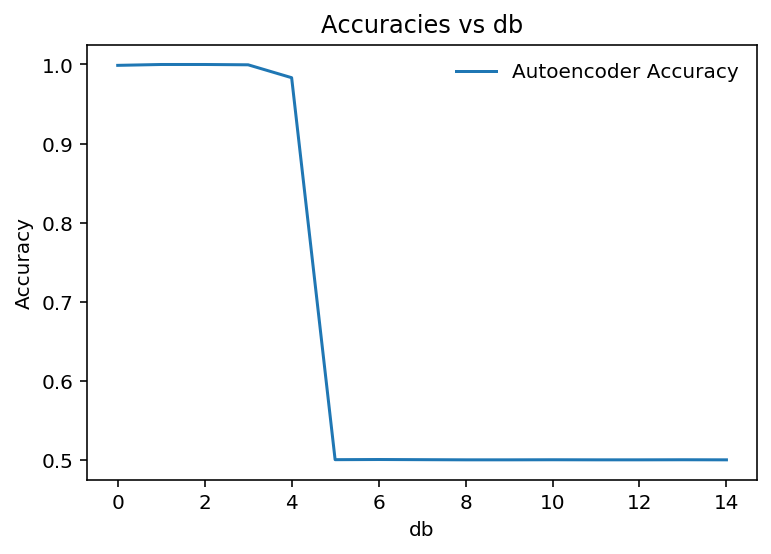

In [142]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.xlabel('db')
plt.ylabel("Accuracy")
plt.plot(accuracy_ae_means_list, label='Autoencoder Accuracy')
plt.legend(frameon=False)
plt.title('Accuracies vs db')
plt.savefig(os.path.join(synthetic_path,f'Accuracies_vs_dbs_autoencoder.png'))

In [0]:
time_start = time.time()
# tsne_model = TSNE(random_state = 42)
# print(f'TSNE started. Time collapsed = {(time.time()-time_start):.2f}s')
# tsne = tsne_model.fit_transform(X)
# print(f'TSNE completed. Time collapsed = {(time.time()-time_start):.2f}s')
# j = 2
for j in range(0, 18):
  tsne = np.load(os.path.join(synthetic_path, f'tsne_sparsity{j+1}.npy') )
  y_pred_train = np.load(os.path.join(synthetic_path, f'gmm_preds_sparsity{j}.npy'))
  for i in range(len(tsne)):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[y_pred_train[i]])
  del tsne
  del y_pred_train 
  print(f'done. Time collapsed ={time.time()-time_start}')
  plt.title(f'Visualization against the predicted clustering by GMM for Sparsity = {j+1}')
  plt.savefig(os.path.join(gmm_path,f'predictedGMM_for_Sparsity_{j+1}.png'))
  plt.clf()

done. Time collapsed =60.104713678359985
done. Time collapsed =122.83830094337463
done. Time collapsed =186.1231939792633
done. Time collapsed =252.53311562538147
done. Time collapsed =316.08072805404663
done. Time collapsed =380.33908104896545
done. Time collapsed =443.3959836959839
done. Time collapsed =506.5995943546295
done. Time collapsed =570.6039922237396
done. Time collapsed =634.7487516403198
done. Time collapsed =698.045307636261
done. Time collapsed =760.759204864502
done. Time collapsed =824.3234689235687
done. Time collapsed =887.3940515518188
done. Time collapsed =950.2635970115662
done. Time collapsed =1016.7553551197052
done. Time collapsed =1079.9479503631592
done. Time collapsed =1142.2407364845276


<Figure size 432x288 with 0 Axes>

In [0]:
time_start = time.time()
for j in range(0, 18):
  tsne = np.load(os.path.join(synthetic_path, f'tsne_sparsity{j+1}.npy') )
  labels = np.load(os.path.join(synthetic_path, f'labels_sparsity{j}.npy'))
  for i in range(len(tsne)):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(labels[i].item())])
    if(i%250==0):
      print('.', end = '')  
  del tsne
  del labels
  print(f'done. Time collapsed ={time.time()-time_start}')
  plt.title(f'Visualization against the ground truth for Sparsity = {j+1}')
  plt.savefig(os.path.join(synthetic_path,f'ground_truth_Sparsity_{j+1}.png'))
  plt.clf()

.........................................done. Time collapsed =59.175854444503784
.........................................done. Time collapsed =122.80003237724304
.........................................done. Time collapsed =186.10533118247986
.........................................done. Time collapsed =250.4526550769806
.........................................done. Time collapsed =315.11538577079773
.........................................done. Time collapsed =379.9024636745453
.........................................done. Time collapsed =444.85881304740906
.........................................done. Time collapsed =509.3098123073578
.........................................done. Time collapsed =573.4106514453888
.........................................done. Time collapsed =637.0743343830109
.........................................done. Time collapsed =700.5381364822388
.........................................done. Time collapsed =763.7549388408661
.......................

<Figure size 432x288 with 0 Axes>

......

KeyboardInterrupt: ignored

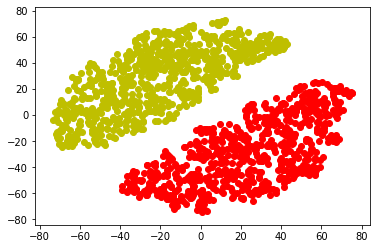

In [0]:
time_start = time.time()
for j in range(0, 18):
  tsne = np.load(os.path.join(synthetic_path, f'tsne_sparsity{j+1}.npy') )
  y_pred_train = np.load(os.path.join(synthetic_path, f'kmeans_preds_sparsity{j}.npy') )
  for i in range(len(tsne)):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(y_pred_train[i].item())]) 
    if(i%250==0):
      print('.', end = '')
  del tsne
  del y_pred_train
  print(f'done. Time collapsed ={time.time()-time_start}')
  plt.title(f'Visualization against the KMeans Prediction for Sparsity = {j+1}')
  plt.savefig(os.path.join(kmeans_path,f'predictedKMeans_for_Sparsity_{j+1}.png'))
  plt.clf()

In [0]:
y_pred_train = torch.from_numpy(y_pred_train).type(torch.ByteTensor)#.cuda()
accuracy = torch.mean((torch.from_numpy(y_pred_train).view(10002) == labels.view(10002)).type(torch.FloatTensor)).item()
print(f'Gaussian Mixture Model Accuracy = {(accuracy)*100:.2f}%')

Gaussian Mixture Model Accuracy = 5.10%


In [0]:
uni = sparse()
(uni[90:96])

torch.Size([39, 1])


tensor([[-1.4063e-01, -2.8145e-01,  4.4411e-01,  5.8321e-02, -2.1524e-01,
          8.6211e-02, -1.0329e-01,  1.2181e-01,  7.2102e-01, -2.8954e-01,
          1.5922e-02,  1.0000e+00,  2.3463e-02, -4.5925e-02, -5.2821e-02,
          3.5522e-01, -1.6904e-04, -4.1855e-01,  1.2959e-01,  3.0241e-01,
         -1.7134e-01, -2.2824e-01, -2.7596e-01, -1.2453e-01, -9.1200e-02,
          1.3983e-01, -2.4867e-01,  4.8624e-02, -1.4572e-01, -9.8532e-02,
          4.0182e-01,  1.1139e-01, -7.1844e-02, -2.2730e-01, -9.3280e-02,
         -6.3991e-01, -9.7520e-02, -3.8303e-01,  4.2248e-01],
        [-6.9391e-01,  3.8642e-01, -3.8027e-01, -4.3062e-01,  3.5098e-01,
         -5.5339e-01,  3.5102e-01, -2.6369e-01, -8.6607e-02, -1.0981e-01,
          2.5792e-01,  1.0000e+00, -1.0263e-01, -1.6609e-01,  2.7656e-01,
          1.4986e-01, -4.4353e-01, -2.9889e-01,  2.4021e-02, -6.1056e-01,
          5.3332e-03,  2.5645e-01,  2.4435e-01, -5.7948e-03, -5.7108e-01,
         -2.6533e-01,  2.5154e-01,  3.0417e-03, -1

## KMeans

In [0]:
kmodel = KMeans(n_clusters = 2, random_state = 42)
y_pred_train = None
time_means_start = time.time()
X = X.cpu()
kmeans = kmodel.fit(X)
print(f'KMeans completed. Time elapsed = {time.time()-time_means_start:.2f}s')
y_pred_train = kmeans.labels_
train_accuracy = torch.mean((torch.from_numpy(y_pred_train).view(10002) == labels.view(10002)).type(torch.FloatTensor)).item()
print(f'KMeans Accuracy = {train_accuracy*100:.2f}%')
print(f'Done time elapsed = {time.time()-time_means_start:.2f}s')

KMeans completed. Time elapsed = 0.18s
KMeans Accuracy = 5.10%
Done time elapsed = 0.18s


.....................................................................................................

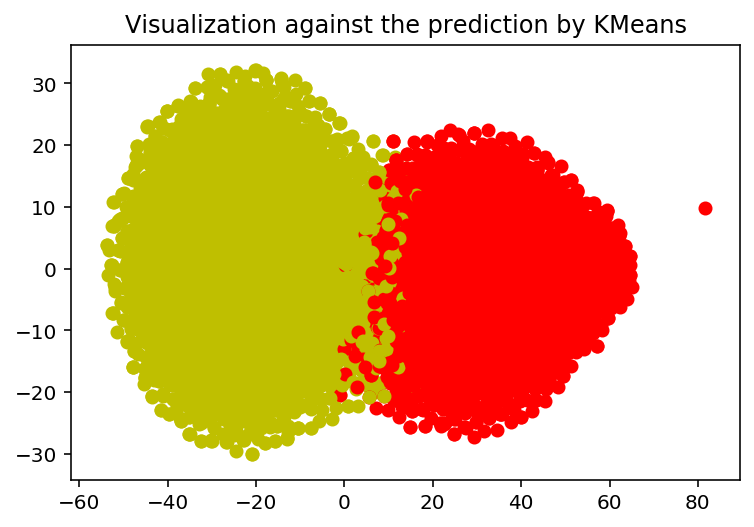

In [0]:
for i in range(len(tsne)):
  plt.scatter(tsne[i][0], tsne[i][1], c=colors[kmeans.labels_[i]])
  if(i%100==0):
    print('.', end = '')  
plt.title('Visualization against the prediction by KMeans')
plt.show()

## Autoencoder

In [0]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Sequential(nn.Linear(39, 2), 
                             nn.LogSoftmax(dim = 1))
  def forward(self, X):
    X = self.fc1(X)
    return X

In [0]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc2 = nn.Sequential(nn.Linear(2,39),
                             nn.Softmax(dim = 1))
  def forward(self, X):
    X = self.fc2(X)
    return X

In [0]:
class Autoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc
    self.dec = dec
  def forward(self, X):
    X = self.enc(X)
    X = self.dec(X)
    return X

In [0]:
enc = encoder()
dec = decoder()
autoencoder = Autoencoder(enc, dec)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

Autoencoder(
  (enc): encoder(
    (fc1): Sequential(
      (0): Linear(in_features=39, out_features=2, bias=True)
      (1): LogSoftmax()
    )
  )
  (dec): decoder(
    (fc2): Sequential(
      (0): Linear(in_features=2, out_features=39, bias=True)
      (1): Softmax(dim=1)
    )
  )
)

In [0]:
epochs = 600
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [0]:
X = X.to(device)

In [0]:
def train():
  
  autoencoder.train()
  train_loss = 0
  
  

  optimizer.zero_grad()

  X_p = autoencoder(X)

  loss = criterion(X_p, X)
  
  loss.backward()
  train_loss += loss.item()
  
  optimizer.step()
  return train_loss

In [0]:
def test():
  autoencoder.eval()
  test_loss = 0

  with torch.no_grad():

    X_p = autoencoder(X)

    loss = criterion(X_p, X)

    test_loss += loss.item()
  return test_loss

In [0]:
train_loss_list = []
# test_loss_list = []
time_start = time.time()
for e in range(epochs):
  
  train_loss = train()
  train_loss /= len(X)
  print(f'Training done. Time Collapsed = {time.time() - time_start: .2f}s')
  # print(f'Testing..')
  # test_loss = test()
  # test_loss /= len(val_data)
  # print(f'Testing done. Time Collapsed = {time.time() - time_start: .2f}s')
  train_loss_list.append(train_loss)
  # test_loss_list.append(test_loss)

Training done. Time Collapsed =  0.00s
Training done. Time Collapsed =  0.01s
Training done. Time Collapsed =  0.01s
Training done. Time Collapsed =  0.01s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Colla

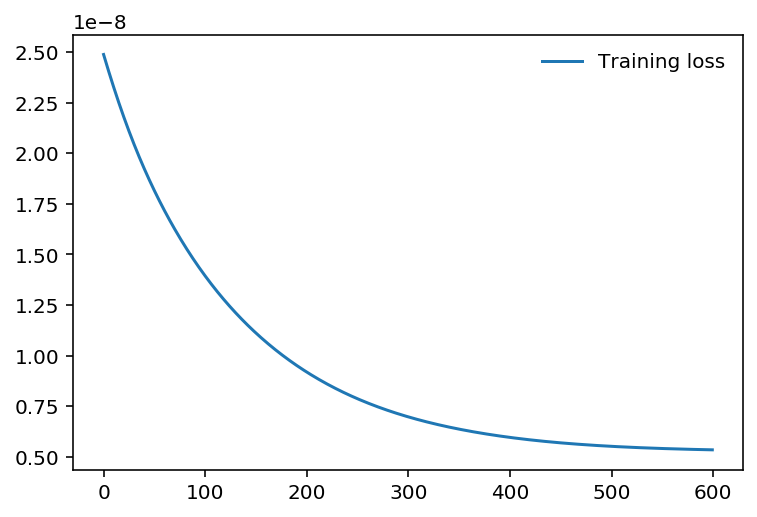

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_loss_list, label='Training loss')
# plt.plot(test_loss_list, label='Validation loss')
plt.legend(frameon=False)

done time elapsed = 63.44s


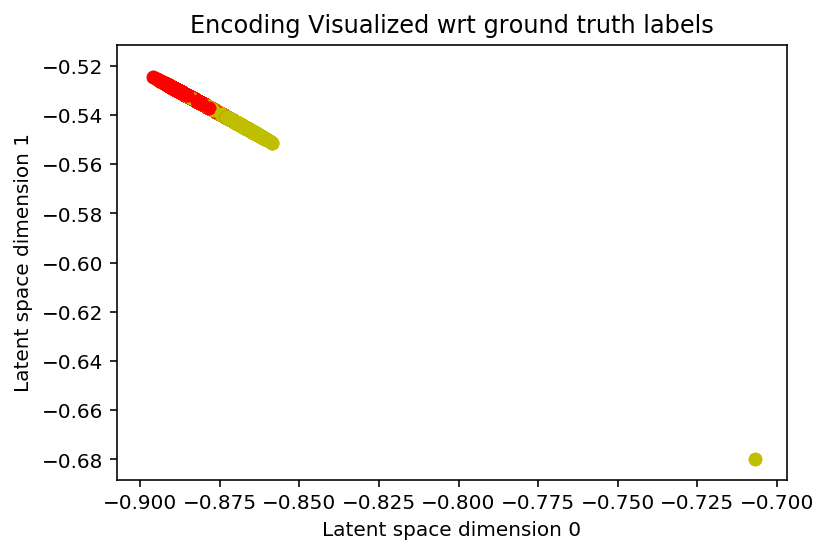

In [0]:
with torch.no_grad():
  enc.eval()
  enc.to(device)
  time_embedding = time.time()
  
  z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  z = z.cpu()
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(labels[i][0].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt ground truth labels')
  plt.show()

In [0]:
y_pred = torch.argmax(z.type(torch.LongTensor), dim = 1)
a = 1 - y_pred.type(torch.ByteTensor).cpu()
labels = labels.cpu()
accuracy = torch.mean((y_pred==labels).type(torch.FloatTensor))
print(f'accuracy = {(accuracy/len(X)*100):.3f}%')

accuracy = 0.005%


In [0]:
1/torch.mean(a.type(torch.FloatTensor))

tensor(10002.)

In [0]:
torch.mean(y_pred.type(torch.FloatTensor))

tensor(0.9999)

done time elapsed = 61.51s


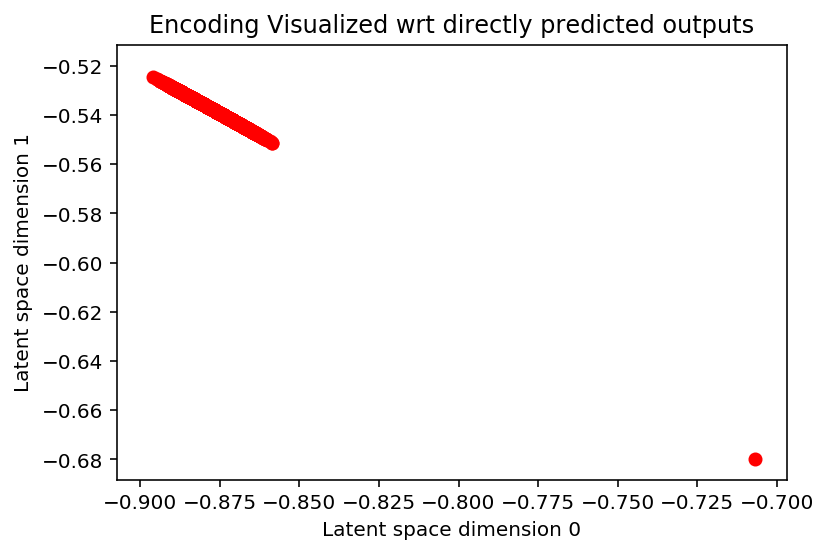

In [0]:
with torch.no_grad():
  # enc.eval()
  # enc.to(device)
  time_embedding = time.time()

  # z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(y_pred[i].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt directly predicted outputs')
  plt.show()

In [0]:
z.shape

torch.Size([10002, 2])

done time elapsed = 60.27s


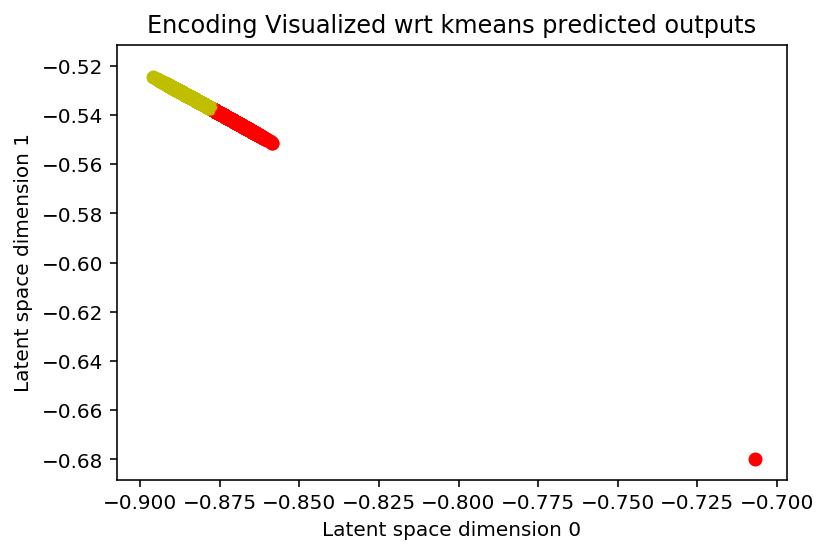

In [0]:
kmeans_auto =  KMeans(n_clusters = 2, random_state = 42)
km = kmeans_auto.fit(z)
kmeans_pred_label = km.labels_
with torch.no_grad():
  # enc.eval()
  # enc.to(device)
  time_embedding = time.time()

  # z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(kmeans_pred_label[i].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt kmeans predicted outputs')
  plt.show()

In [0]:
train_accuracy = torch.mean((torch.from_numpy(kmeans_pred_label).view(10002) == labels.view(10002)).type(torch.FloatTensor)).item()
print(f'KMeans Accuracy on Encoding by Autoencoder = {train_accuracy*100:.2f}%')

KMeans Accuracy on Encoding by Autoencoder = 17.44%


In [0]:
np.mean((kmeans_pred_label==np.ones(kmeans_pred_label.shape)).astype('float32'))

0.5

In [0]:
kmeans_pred_label.shape

(10002,)

In [0]:
wrong_pred_list = []
for i in range(len(kmeans_pred_label)):
  if(kmeans_pred_label[i].item() != labels[i].item()): 
    wrong_pred_list.append(i)
    print(i)
print(len(wrong_pred_list))

10002


In [0]:
torch.sum((torch.from_numpy(kmeans_pred_label) == labels).type(torch.FloatTensor)).item()

50020000.0

In [0]:
zz = (torch.from_numpy(kmeans_pred_label).view(10002) == labels.view(10002))

In [0]:
kmeans_pred_label.shape

(10002,)

In [0]:
torch.mean(zz.type(torch.FloatTensor))

tensor(1.)

In [0]:
wrong_pred_list = []
for i,j in enumerate(zz):
  if (not j and (kmeans_pred_labels[i].item() != labels[i].item())):
    wrong_pred_list.append(i)
print(len(wrong_pred_list))

RuntimeError: ignored

In [0]:
zz.shape

torch.Size([10002])

In [0]:
for i,j in enumerate(zz):
  print(j)
  if i >5:
    break


tensor([ True,  True, False,  ...,  True, False,  True])
tensor([ True,  True, False,  ...,  True, False,  True])
tensor([False, False,  True,  ..., False,  True, False])
tensor([ True,  True, False,  ...,  True, False,  True])
tensor([False, False,  True,  ..., False,  True, False])
tensor([False, False,  True,  ..., False,  True, False])
tensor([ True,  True, False,  ...,  True, False,  True])


In [0]:
a = torch.randint(low = 0, high = 2, size = (10002,))
b = a.numpy()
c = ((torch.from_numpy(b) == a).type(torch.FloatTensor))
print(c)

tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [0]:
c.shape

torch.Size([10002])

In [0]:
nn.Flatten()(labels).shape

torch.Size([10002, 1])

## VAE

In [0]:
class encoder_v(nn.Module):
  def __init__(self):
    super().__init__()
    self.mu = nn.Sequential(nn.Linear(39, 2), 
                             nn.LogSoftmax(dim = 1))
    self.var = nn.Sequential(nn.Linear(39, 2), 
                             nn.LogSoftmax(dim = 1))
  def forward(self, X):
    z_mu = self.mu(X)
    z_var = self.var(X)
    return z_mu, z_var

In [0]:
class decoder_v(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc2 = nn.Sequential(nn.Linear(2,39),
                             nn.Softmax(dim = 1))
  def forward(self, X):
    X = self.fc2(X)
    return X

In [0]:
class VAutoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc
    self.dec = dec
  def forward(self, X):
    z_mu, z_var = self.enc(X)
    std = torch.exp( z_var/2 )
    eps = torch.randn_like(std)
    z_sample = eps.mul(std).add_(z_mu)
    X_predic = self.dec(z_sample)
    return X_predic, z_mu, z_var

In [0]:
enc_v = encoder_v()
dec_v = decoder_v()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vautoencoder = VAutoencoder(enc_v, dec_v).to(device)
optimizer = torch.optim.Adam(vautoencoder.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [0]:
X = X.to(device)

In [0]:
def train():
  
  vautoencoder.train()
  train_loss = 0
  

  optimizer.zero_grad()

  X_pred, z_mu, z_var = vautoencoder(X)

  recon_loss = criterion(X_pred, X)
  kl_loss = 0.5*( torch.sum( torch.exp(z_var) + z_mu**2 - 1.0 + z_var ) ) 
  loss = recon_loss + kl_loss

  loss.backward()
  train_loss += loss.item()
  
  optimizer.step()
  return train_loss

In [0]:
# def test():
#   vautoencoder.eval()
#   test_loss = 0

#   with torch.no_grad():

#     X_ped, z_mu, z_var = vautoencoder(images)

#     recon_loss = criterion(X, images)
#     kl_loss = 0.5*torch.sum(torch.exp(z_var)+ z_mu**2 - 1 + z_var)
#     loss = recon_loss + kl_loss

#     test_loss += loss.item()      
#   return test_loss

In [0]:
epochs = 1000

In [0]:
train_loss_list = []
test_loss_list = []
time_start = time.time()
for e in range(epochs):
  print(f'{e+1}th epoch...')
  print(f'Training...')
  train_loss = train()
  train_loss /= len(X)
  print(f'Training done. Time Collapsed = {time.time() - time_start: .2f}s')
  # print(f'Testing..')
  # test_loss = test()
  # test_loss /= len(val_data)
  # print(f'Testing done. Time Collapsed = {time.time() - time_start: .2f}s')
  train_loss_list.append(train_loss)
  # test_loss_list.append(test_loss)

1th epoch...
Training...
Training done. Time Collapsed =  0.01s
2th epoch...
Training...
Training done. Time Collapsed =  0.01s
3th epoch...
Training...
Training done. Time Collapsed =  0.02s
4th epoch...
Training...
Training done. Time Collapsed =  0.02s
5th epoch...
Training...
Training done. Time Collapsed =  0.02s
6th epoch...
Training...
Training done. Time Collapsed =  0.03s
7th epoch...
Training...
Training done. Time Collapsed =  0.03s
8th epoch...
Training...
Training done. Time Collapsed =  0.03s
9th epoch...
Training...
Training done. Time Collapsed =  0.04s
10th epoch...
Training...
Training done. Time Collapsed =  0.04s
11th epoch...
Training...
Training done. Time Collapsed =  0.04s
12th epoch...
Training...
Training done. Time Collapsed =  0.05s
13th epoch...
Training...
Training done. Time Collapsed =  0.05s
14th epoch...
Training...
Training done. Time Collapsed =  0.05s
15th epoch...
Training...
Training done. Time Collapsed =  0.06s
16th epoch...
Training...
Training

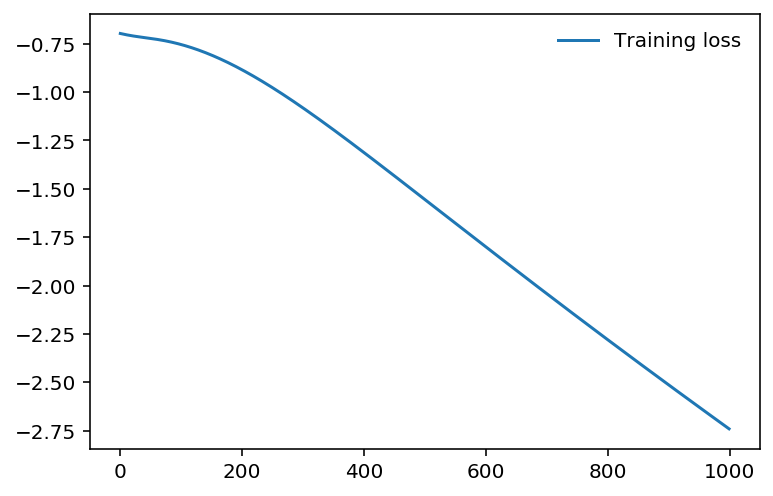

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_loss_list, label='Training loss')
plt.legend(frameon=False)

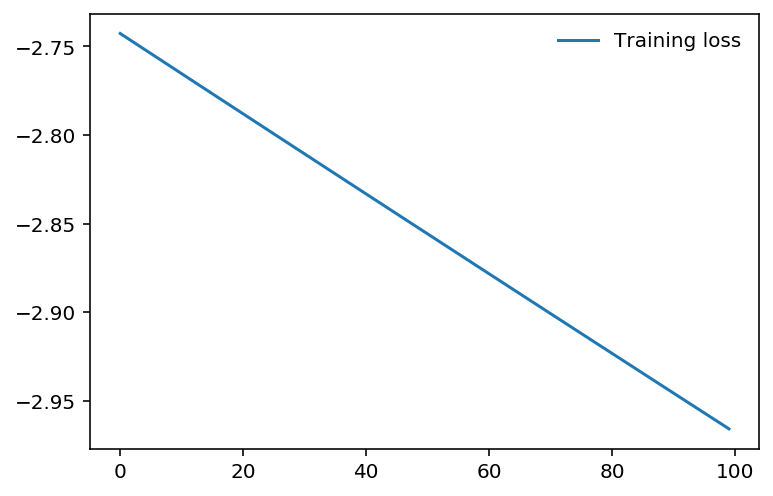

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_loss_list, label='Training loss')
plt.legend(frameon=False)

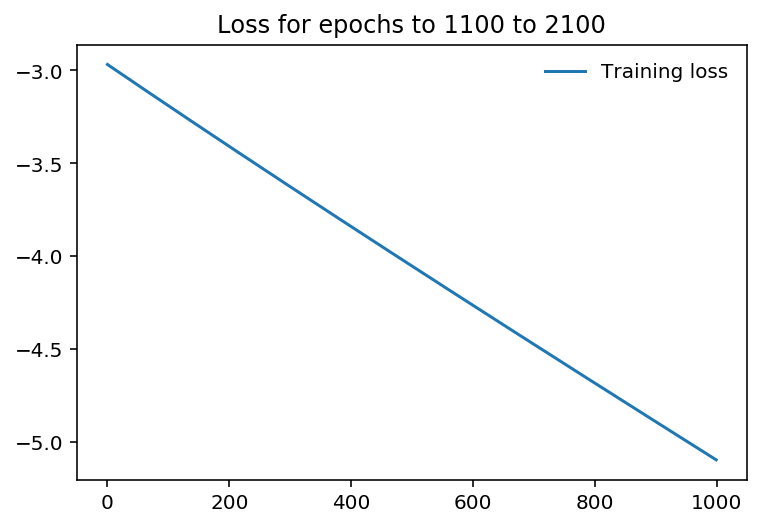

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_loss_list, label='Training loss')
plt.title("Loss for epochs to 1100 to 2100")
plt.legend(frameon=False)

In [0]:
X.shape

torch.Size([10002, 39])

# DEC

In [50]:

  autoencoder, encoder = autoencoder(dims, init=init)
  autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
  fits = autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
  # autoencoder.save_weights(os.path.join(synthetic_path, f"ae_sparsity_1_db_{db}.h5"))
  encoding = encoder.predict(X)
  # np.save(os.path.join(synthetic_path, f'encoding_sparsity_1_db_{db}.npy'), encoding) 
  #============#
  clustering_layer = ClusteringLayer(n_clusters = 2, name='clustering')(encoder.output)
  model = Model(inputs=encoder.input, outputs=clustering_layer)
  model.compile(optimizer=Adam(0.01), loss='kld')
  k_means = KMeans(n_clusters=2, n_init=20)
  y_pred_ae = k_means.fit_predict(encoding) 
  y_pred_last = np.copy(y_pred_ae)
  model.get_layer(name='clustering').set_weights([k_means.cluster_centers_])
  #===================#
  loss = 0
  index = 0
  maxiter = 8000
  update_interval = 140
  index_array = np.arange(X.shape[0])
  tol = 0.001 
  acc = 0
  #=====================#
  for ite in range(int(maxiter)):
      if ite % update_interval == 0:
          q = model.predict(X, verbose=0)
          p = target_distribution(q) 
          y_pred_ae = q.argmax(1)
          print(y_pred_ae.shape)
          print(labels.numpy().shape)
          if labels.numpy() is not None:
              acc = np.round(metrics.acc(labels.numpy().reshape(10002,), y_pred_ae), 5)
              nmi = np.round(metrics.nmi(labels.numpy().reshape(10002,), y_pred_ae), 5)
              ari = np.round(metrics.ari(labels.numpy().reshape(10002,), y_pred_ae), 5)
              loss = np.round(loss, 5)
              print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)
          delta_label = np.sum(y_pred_ae != y_pred_last).astype(np.float32) / y_pred_ae.shape[0]
          y_pred_last = np.copy(y_pred_ae)
          if ite > 0 and delta_label < tol:
              print('delta_label ', delta_label, '< tol ', tol)
              print('Reached tolerance threshold. Stopping training.')
              break
      idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
      loss = model.train_on_batch(x=X[idx], y=p[idx])
      index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0
  accuracy_dec_list.append(acc)
  # model.save_weights(os.path.join(synthetic_path, f'DEC_model_final_sparsity_1_db{db}.h5'))
  encoded_dec = encoder.predict(X)
  # np.save(os.path.join(synthetic_path, f'encoded_dec_sparsity_1_db_{db}.npy'), encoded_dec)
  # del encoding, loss, idx, index, model,acc,nmi, ari, clustering_layer, k_means, y_pred_last, delta_label, encoded_dec
  #===========================#

Epoch 1/30
10002/10002 [==============================] - 2s 174us/step - loss: 0.1020
Epoch 2/30
10002/10002 [==============================] - 1s 59us/step - loss: 0.0052
Epoch 3/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0050
Epoch 4/30
10002/10002 [==============================] - 1s 57us/step - loss: 0.0048
Epoch 5/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0050
Epoch 6/30
10002/10002 [==============================] - 1s 57us/step - loss: 0.0034
Epoch 7/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0027
Epoch 8/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0026
Epoch 9/30
10002/10002 [==============================] - 1s 59us/step - loss: 0.0031
Epoch 10/30
10002/10002 [==============================] - 1s 57us/step - loss: 0.0026
Epoch 11/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0025
Epoch 12/30
10002/10002 [==========================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.98170, nmi = 0.88624, ari = 0.92815  ; loss= 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.98130, nmi = 0.88433, ari = 0.92661  ; loss= 0.0
delta_label  0.0009998000399920016 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


<function matplotlib.pyplot.show>

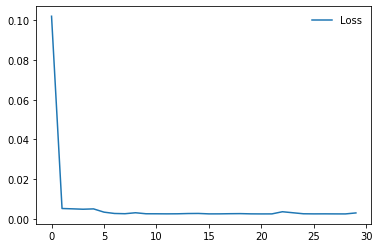

In [51]:
plt.plot(fits.history['loss'], label = 'Loss')
plt.legend(frameon = False)
plt.show